<a href="https://colab.research.google.com/github/dinaglamshowroom/projet-data_oc/blob/main/projet_4_livrable_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analyse des ventes d’une librairie
Après avoir procédé au nettoyage et à la préparation des données dans la première partie du projet, nous allons désormais nous concentrer sur l’analyse des ventes de l’entreprise. Cette étape a pour objectif de dégager les principaux indicateurs de performance (CA, volume, panier moyen), d’identifier les profils clients les plus contributifs, ainsi que de mettre en évidence les tendances et disparités selon les catégories de produits, l’âge ou le sexe des acheteurs. L’analyse vise ainsi à fournir une vision claire et structurée de l’activité commerciale, étape préalable à la formulation de recommandations stratégiques.





>








## 1. Chargement et fusion des données

 Thème automnal activé (Matplotlib + Seaborn)


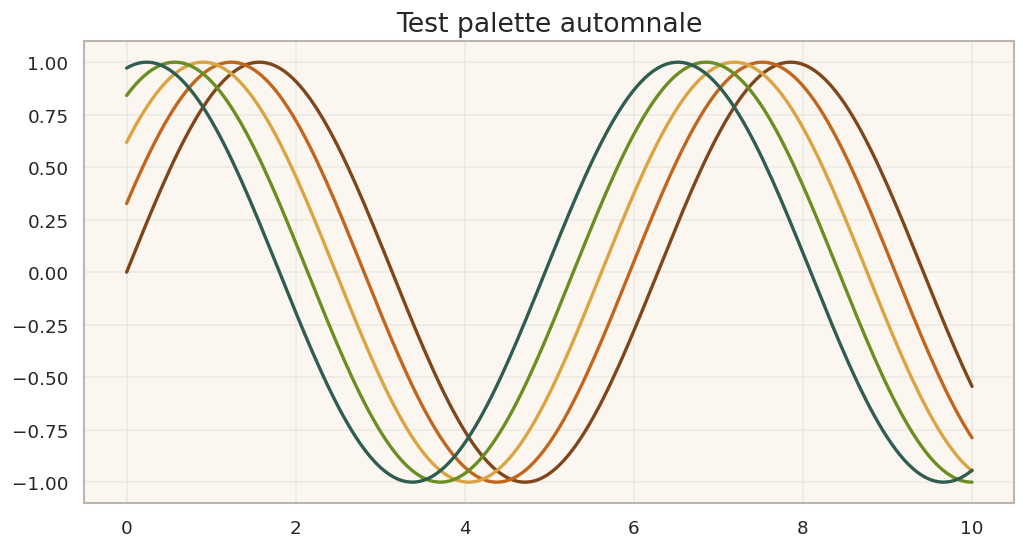

,id_prod,date,session_id,client_id,month,price,categ,sex,birth,age,CA
0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450,2021-04,4.99,0,f,1977,48,4.99
1,2_226,2022-02-03 01:55:53.276402,s_159142,c_277,2022-02,65.75,2,f,2000,25,65.75
2,1_374,2021-09-23 15:13:46.938559,s_94290,c_4270,2021-09,10.71,1,f,1979,46,10.71
3,0_2186,2021-10-17 03:27:18.783634,s_105936,c_4597,2021-10,4.20,0,m,1963,62,4.20
4,0_1351,2021-07-17 20:34:25.800563,s_63642,c_1242,2021-07,8.99,0,f,1980,45,8.99


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import matplotlib.pylab as pylab
from matplotlib import cycler


AUTUMN_PALETTE = [
    "#7F461B",  # châtaigne
    "#C1661C",  # orange brûlé
    "#D9A441",  # ocre doré
    "#6B8E23",  # olive
    "#2F5D50",  # vert pin
    "#8C2F39",  # bordeaux
    "#A46843",  # cannelle
    "#B98B2E",  # moutarde
]

# Seaborn
sns.set_theme(context="notebook", style="whitegrid", palette=AUTUMN_PALETTE)

# Matplotlib (sync palette + réglages lisibles)
plt.rcParams.update({
    "figure.figsize": (10, 5),
    "figure.dpi": 120,
    "axes.titlesize": 16,
    "axes.labelsize": 13,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "axes.facecolor": "#FBF7F0",
    "axes.edgecolor": "#BDB6AE",
    "grid.alpha": 0.3,
    "axes.prop_cycle": cycler(color=AUTUMN_PALETTE),  # 👈 couleurs auto pour plt.plot/hist
})

print(" Thème automnal activé (Matplotlib + Seaborn)")


# Exemple de test : plusieurs courbes devraient avoir des couleurs automnales différentes
import numpy as np
x = np.linspace(0, 10, 200)
for i in range(5):
    plt.plot(x, np.sin(x + i/3), linewidth=2)
plt.title("Test palette automnale")
plt.show()


# Conversion des dates
df_transactions['date'] = pd.to_datetime(df_transactions['date'])

# Fusion des tables
df = df_transactions.merge(df_products, on='id_prod', how='left')
df = df.merge(df_customers, on='client_id', how='left')

# Création du chiffre d'affaires (CA)
df['CA'] = df['price']
df['month'] = df['date'].dt.to_period('M')
df.head()

In [ ]:
#autorisation d'acces au google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

#importation des données depuis un ficher dans google drive
import os, glob

DATA_DIR = "/content/drive/MyDrive/Projet_P4/Data_p4_clean"
csv_files = glob.glob(os.path.join(DATA_DIR, "*.csv"))

print("Fichiers CSV trouvés :")
for f in csv_files:
    print(f)

# Charger tous les CSV dans un dictionnaire
import pandas as pd
dfs = {f.split("/")[-1]: pd.read_csv(f) for f in csv_files}

Mounted at /content/drive
Fichiers CSV trouvés :
/content/drive/MyDrive/Projet_P4/Data_p4_clean/transactions_clean.csv
/content/drive/MyDrive/Projet_P4/Data_p4_clean/transactions_final.csv
/content/drive/MyDrive/Projet_P4/Data_p4_clean/customers_final.csv
/content/drive/MyDrive/Projet_P4/Data_p4_clean/products_final.csv
/content/drive/MyDrive/Projet_P4/Data_p4_clean/customers_clean.csv
/content/drive/MyDrive/Projet_P4/Data_p4_clean/products_clean.csv


**Configuration Pandas**

In [ ]:

# Afficher toutes les colonnes sans troncature
pd.set_option("display.max_columns", None)
# Limiter le nombre de lignes affichées
pd.set_option("display.max_rows", 100)
# Formater les floats pour plus de lisibilité
pd.set_option("display.float_format", lambda x: "%.2f" % x)

**Création de la table de fait df_tf**

##Création de la mega DataFrame (df_tf)

Sachant que:

* transactions = table de faits (chaque ligne = un achat)

* products = table de dimensions (prix, catégorie des produits)

* customers = table de dimensions (sexe, date de naissance des clients)

Nous allons créé une table de faits enrichie en joignant les 3 dataframes. On obtient alors une seule mega DataFrame (df_tf) qui contient :

* Grain : une ligne = une transaction.

* Mesures : prix, CA, volume.

* Dimensions : tout ce qui décrit la transaction (produit, catégorie, client, sexe, âge, date…).


In [ ]:
#appeler et renommer les dataframes
df_customers= dfs["customers_clean.csv"]
df_products = dfs["products_clean.csv"]
df_transactions = dfs["transactions_clean.csv"]

In [ ]:


# Assurer des chaînes propres (déjà fait, mais proprement pour éviter l’avertissement)
df_transactions.loc[:, "id_prod"] = df_transactions["id_prod"].astype(str).str.strip()
df_products.loc[:, "id_prod"] = df_products["id_prod"].astype(str).str.strip()

print("client_id unique dans customers ?", df_customers["client_id"].is_unique)
print("nid_prod est unique ?", df_products["id_prod"].is_unique)

# --- Doublons réels dans transactions ---
print("Doublons exacts de lignes transactions :", df_transactions.duplicated().sum())

# --- Doublons réels dans customers ---
print("Doublons exacts de lignes customers :", df_customers.duplicated().sum())

# --- Doublons réels dans products ---
print("Doublons exacts de lignes products :", df_products.duplicated().sum())

# Clients référencés dans transactions mais absents de customers (problème d'intégrité)
invalid_clients = set(df_transactions["client_id"]) - set(df_customers["client_id"])
print("Clients dans transactions mais pas dans customers :", len(invalid_clients))

# Produits référencés dans transactions mais absents de customers (problème d'intégrité)
invalid_products = set(df_transactions["id_prod"]) - set(df_products["id_prod"])
print("Produits dans transactions mais pas dans products :", len(invalid_products))

# Vérifier que des lignes entieres ne soient dupliquées
print("Doublons exacts de lignes transactions :", df_transactions.duplicated().sum())

df_customers = df_customers[(df_customers.client_id != 'ct_0') & (df_customers.client_id != 'ct_1')]

client_id unique dans customers ? True
nid_prod est unique ? True
Doublons exacts de lignes transactions : 0
Doublons exacts de lignes customers : 0
Doublons exacts de lignes products : 0
Clients dans transactions mais pas dans customers : 0
Produits dans transactions mais pas dans products : 0
Doublons exacts de lignes transactions : 0


In [ ]:
#Conversion des valeurs de la colonne 'date' dans le bon format date (méthode .to_datetime()),
df_transactions["date"] = pd.to_datetime(
    df_transactions["date"],
    format="%Y-%m-%d %H:%M:%S.%f",
    errors="coerce"
)
df_transactions['month'] = df_transactions['date'].dt.to_period('M')


In [ ]:
# Jointures de la "megadataframe" table de faits
df_tf = (
    df_transactions
      .merge(df_products,  on="id_prod",    how="left")
      .merge(df_customers, on="client_id",  how="left")
)
df_tf.head()

,id_prod,date,session_id,client_id,month,price,categ,sex,birth,age
0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450,2021-04,4.99,0,f,1977,48
1,2_226,2022-02-03 01:55:53.276402,s_159142,c_277,2022-02,65.75,2,f,2000,25
2,1_374,2021-09-23 15:13:46.938559,s_94290,c_4270,2021-09,10.71,1,f,1979,46
3,0_2186,2021-10-17 03:27:18.783634,s_105936,c_4597,2021-10,4.20,0,m,1963,62
4,0_1351,2021-07-17 20:34:25.800563,s_63642,c_1242,2021-07,8.99,0,f,1980,45


# Analyse des données

L’analyse suivra une démarche progressive, répondant aux exigences fixées :

**Exploration descriptive des données**

Présentation des principales variables disponibles (quantitatives et qualitatives).

Calcul d’indicateurs de tendance centrale et de dispersion (moyenne, médiane, écart-type, minimum, maximum).

**Analyse de la distribution des ventes**

  - Étude de la concentration du chiffre d’affaires par client et par produit.

  - Construction d’une courbe de Lorenz et calcul de l’indice de Gini pour mesurer l’inégalité de répartition des ventes.

**Visualisation des données**

  - Réalisation de représentations graphiques variées :

  - Histogrammes (ex. distribution des prix, des âges).

  - Boîtes à moustaches (boxplots) pour détecter valeurs extrêmes et comparer des groupes.

  - Séries temporelles (évolution des ventes dans le temps).


##Exploration descriptive des données

###KPIs globaux

In [ ]:


# ======================
# 1. KPIs globaux
# ======================
print("=== KPIs GLOBAUX ===")
print("Nombre total de transactions :", len(df_tf))
print("Nombre de clients uniques :", df_tf["client_id"].nunique())
print("Nombre de produits distincts vendus :", df_tf["id_prod"].nunique())
print("CA total :", df_tf["price"].sum())

=== KPIs GLOBAUX ===
Nombre total de transactions : 336713
Nombre de clients uniques : 8600
Nombre de produits distincts vendus : 3264
CA total : 5796577.7700000005


Avec 336 713 transactions réalisées par 8 600 clients uniques, l'entreprise a généré un chiffre d'affaires total de 5,8 millions d'euros en vendant 3 264 produits distincts."

## 2. Statistiques descriptives du chiffre d’affaires

In [ ]:
# Statistiques de tendance centrale et dispersion
stats = df_tf['price'].describe()
IQR = stats['75%'] - stats['25%']
print(stats)
print(f'IQR : {IQR:.2f}')




count   336713.00
mean        17.22
std         17.86
min          0.62
25%          8.61
50%         13.90
75%         18.99
max        300.00
Name: price, dtype: float64
IQR : 10.38


In [ ]:
lower_bound = stats['25%'] - 1.5 * IQR
upper_bound = stats['75%'] + 1.5 * IQR
outliers = df_tf[(df_tf['price'] < lower_bound) | (df_tf['price'] > upper_bound)]
filtered_df = df_tf[(df_tf['price'] >= lower_bound) & (df_tf['price'] <= upper_bound)]
filtered_df.head(5)

,id_prod,date,session_id,client_id,month,price,categ,sex,birth,age
0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450,2021-04,4.99,0,f,1977,48
2,1_374,2021-09-23 15:13:46.938559,s_94290,c_4270,2021-09,10.71,1,f,1979,46
3,0_2186,2021-10-17 03:27:18.783634,s_105936,c_4597,2021-10,4.20,0,m,1963,62
4,0_1351,2021-07-17 20:34:25.800563,s_63642,c_1242,2021-07,8.99,0,f,1980,45
5,0_1085,2021-09-15 05:47:48.215162,s_90139,c_2526,2021-09,3.99,0,f,1982,43


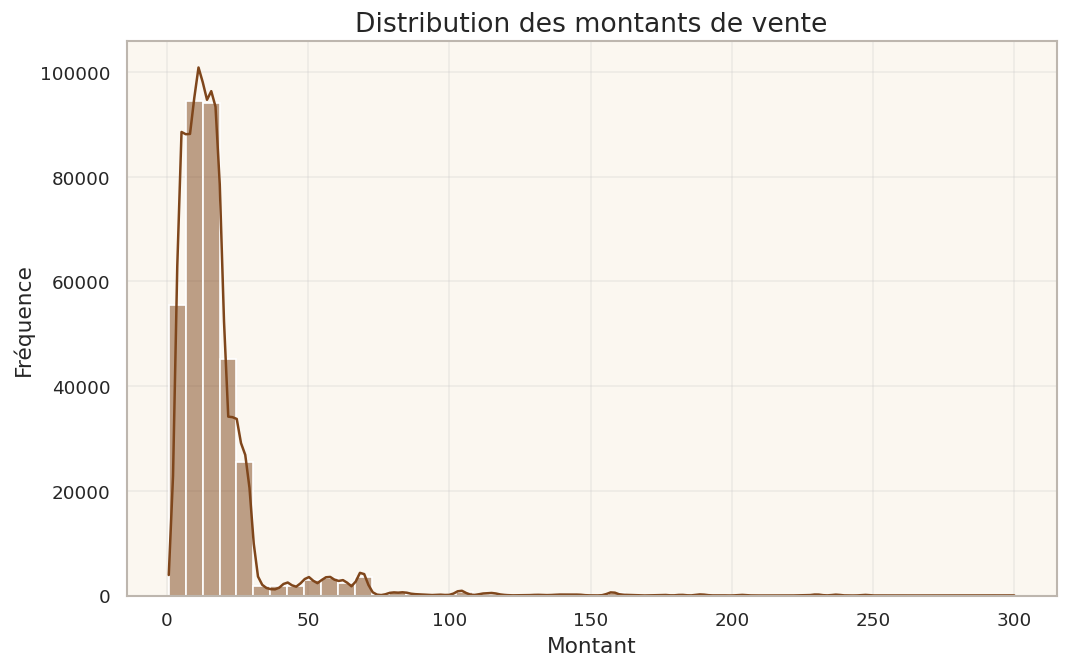

In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(df['price'], bins=50, kde=True)
plt.title('Distribution des montants de vente')
plt.xlabel('Montant')
plt.ylabel('Fréquence')
plt.show()

**Interprétation :** Les prix sont assez variés, avec un maximum (300 €) bien plus élevé que la moyenne (17,22 €), ce qui suggère des outliers.

L’IQR de 10,38 € montre une dispersion modérée entre les prix du 1er et 3e quartile (les 50 % centraux).

La médiane (13,90 €) est inférieure à la moyenne → la distribution des prix est probablement asymétrique vers les valeurs hautes (présence de produits chers).

###Analyse temporelle ( par mois)

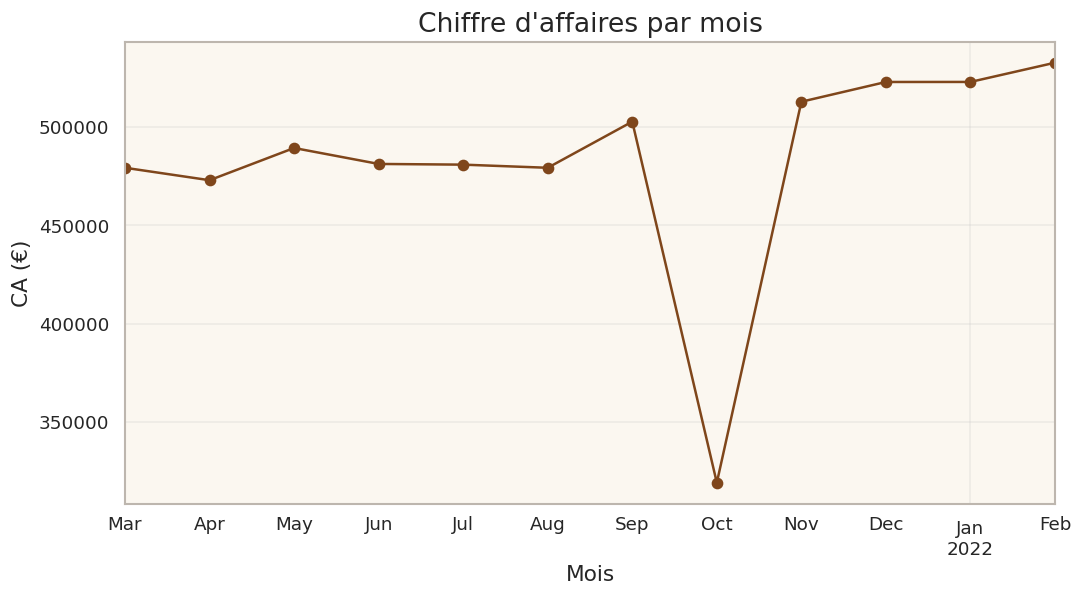

In [ ]:
# ======================
# 2. Analyse temporelle
# ======================
df_tf["month"] = df_tf["date"].dt.to_period("M")
ca_by_month = df_tf.groupby("month")["price"].sum()

plt.figure(figsize=(10,5))
ca_by_month.plot(kind="line", marker="o", title="Chiffre d'affaires par mois")
plt.ylabel("CA (€)") #Définit axe des ordonées
plt.xlabel("Mois") #Définit axe des abcysses
plt.show()

on remarque une incohérence au mois d'octobre, on va donc essayer de comprendre ce qui ce passe durant ce mois: création d'une df ciblée

In [ ]:
# CA mensuel (année-mois, trié)
df_ca_mensuel = (df_tf.groupby("month")["price"].sum().to_timestamp())
  # Period -> Timestamp pour tracés

print(df_ca_mensuel)                 # vision globale (2021-05 → 2022-02)
print("\nPlus précisément: CA Oct 2021 =", df_ca_mensuel.loc["2021-10-01"])  # contrôle ciblé

month
2021-03-01   479312.03
2021-04-01   472980.72
2021-05-01   489367.95
2021-06-01   481257.94
2021-07-01   480898.66
2021-08-01   479305.19
2021-09-01   502771.28
2021-10-01   319159.96
2021-11-01   512890.17
2021-12-01   522937.68
2022-01-01   522955.31
2022-02-01   532740.88
Freq: MS, Name: price, dtype: float64

Plus précisément: CA Oct 2021 = 319159.96


####*analyse des transaction du mois d'octobre*

In [ ]:
# Diagnostic complémentaire sur Octobre 2021
oct21_vol = df_tf[df_tf["month"] == "2021-10"]

print("Transactions Oct 2021 :", oct21_vol.shape) #(nombre de transaction,nb variables conservées)
print(oct21_vol["price"].describe())       # prix anormaux ?

Transactions Oct 2021 : (21577, 10)
count   21577.00
mean       14.79
std        17.54
min         0.62
25%         6.99
50%        11.03
75%        15.99
max       247.22
Name: price, dtype: float64


In [ ]:
# Prix moyen par mois
prix_moyen_mensuel = df_tf.groupby("month")["price"].mean()
print(prix_moyen_mensuel)


month
2021-03   16.78
2021-04   16.65
2021-05   17.33
2021-06   17.95
2021-07   19.46
2021-08   18.72
2021-09   15.12
2021-10   14.79
2021-11   18.14
2021-12   16.13
2022-01   17.84
2022-02   18.02
Freq: M, Name: price, dtype: float64


In [ ]:
# CA moyen par transaction en octobre vs autres
print("CA moyen Oct 2021 :", oct21_vol["price"].mean())
print("CA moyen autres mois :", df_tf[df_tf["month"] != "2021-10"]["price"].mean())

CA moyen Oct 2021 : 14.791674468183714
CA moyen autres mois : 17.38112373705321


Octobre 2021 présente un chiffre d’affaires exceptionnellement bas: 319 k€ vs ~ 490 k€ en moyenne mensuelle. La chute est de −35 % par rapport à la moyenne mensuelle. Cela correspond à un manque d’environ 171 k€, soit ~3 % du CA total sur la période.

L’analyse détaillée montre que le prix moyen reste stable: ~15 €, mais que le nombre de transactions enregistrées 21 577 est nettement inférieur à celui des mois voisins: ~30–35k.

Cela reste faible à l’échelle globale, mais significatif dans une analyse mensuelle, car le mois d’octobre apparaît artificiellement comme une contre-performance.

Cette baisse est donc sans doute liée à un volume de transactions incomplet (probablement dû à un à un volume de transactions incomplet (probablement dû à un problème de collecte ou d’intégration des données)
à un incident opérationnel ( indisponibilité du site, bug technique ayant limité les ventes etc...)
et non à une variation commerciale réelle.




In [ ]:
# Catégories globales (sur toute la période)
all_categ = set(df_tf["categ"].dropna().unique())

# Catégories présentes en octobre 2021
oct_categ = set(
    df_tf.loc[df_tf["date"].dt.to_period("M") == "2021-10", "categ"].dropna().unique()
)

# Catégories manquantes en octobre
missing_categ = all_categ - oct_categ

print("Toutes catégories :", all_categ)
print("Catégories en octobre :", oct_categ)
print("Catégories manquantes en octobre :", missing_categ)


Toutes catégories : {np.int64(0), np.int64(1), np.int64(2)}
Catégories en octobre : {np.int64(0), np.int64(1), np.int64(2)}
Catégories manquantes en octobre : set()


In [ ]:
# 0) Copie + jour calendaire
df_tmp = df_tf.copy()
df_tmp["day"] = df_tmp["date"].dt.floor("D")

# 1) Restreindre à Octobre 2021
mask_oct = df_tmp["day"].between("2021-10-01", "2021-10-31", inclusive="both")
df_oct = df_tmp.loc[mask_oct].copy()

# 2) (Option) s'assurer que categ est bien numérique si nécessaire
# df_oct["categ"] = pd.to_numeric(df_oct["categ"], errors="coerce")




In [ ]:
pivot_oct = (
    df_oct.pivot_table(index="day", columns="categ", values="id_prod", aggfunc="count", fill_value=0)
)
pivot_oct["nb_tx_total"] = pivot_oct.sum(axis=1)
print(pivot_oct)

categ         0    1   2  nb_tx_total
day                                  
2021-10-01  662  344  37         1043
2021-10-02  660    0  27          687
2021-10-03  647    0  30          677
2021-10-04  600    0  37          637
2021-10-05  594    0  38          632
2021-10-06  701    0  25          726
2021-10-07  597    0  26          623
2021-10-08  669    0  44          713
2021-10-09  640    0  35          675
2021-10-10  599    0  28          627
2021-10-11  642    0  42          684
2021-10-12  632    0  29          661
2021-10-13  633    0  36          669
2021-10-14  605    0  39          644
2021-10-15  632    0  37          669
2021-10-16  661    0  45          706
2021-10-17  625    0  44          669
2021-10-18  608    0  37          645
2021-10-19  565    0  37          602
2021-10-20  554    0  42          596
2021-10-21  610    0  43          653
2021-10-22  571    0  34          605
2021-10-23  555    0  47          602
2021-10-24  584    0  44          628
2021-10-25  

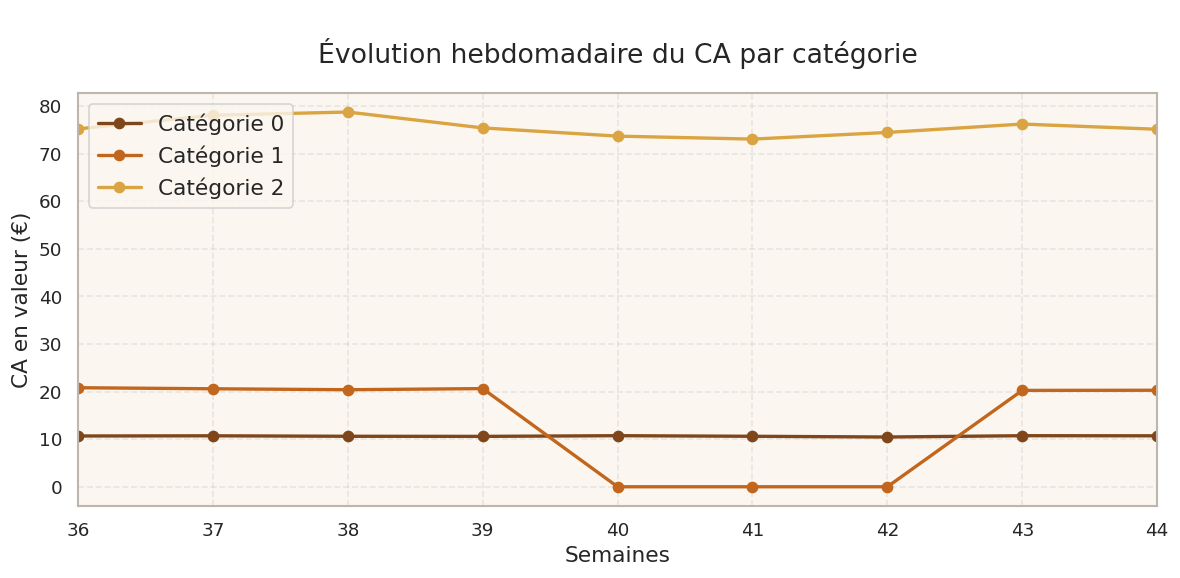

In [ ]:
# --- Préparation des données ---
d = df_tf.copy()

# Semaine ISO (1..53) en entier
d['semaine'] = d['date'].dt.isocalendar().week.astype(int)

# S'assurer que categ est bien entier (si nécessaire)
d['categ'] = pd.to_numeric(d['categ'], errors='coerce').astype('Int64')

# Agrégation hebdo x catégorie (moyenne comme dans ton code, mets .sum() si tu veux le total)
weekly = (
    d.groupby(['semaine', 'categ'])['price']
     .mean()                             # <- .sum() pour le CA total hebdo
     .reset_index()
)

# Filtre semaines 36..44 inclus
weekly = weekly[(weekly['semaine'] >= 36) & (weekly['semaine'] <= 44)]

# Pivot pour avoir 1 colonne par catégorie
pivot = weekly.pivot(index='semaine', columns='categ', values='price').sort_index()

# S'assurer que toutes les semaines existent (36..44), NaN -> 0
weeks = pd.Index(range(36, 45), name='semaine')
pivot = pivot.reindex(weeks).fillna(0)

# Ordre des catégories attendu (0,1,2) si présent
cats = [c for c in [0, 1, 2] if c in pivot.columns]

# --- Tracé en courbes ---
fig, ax = plt.subplots()

for i, c in enumerate(cats):
    ax.plot(
        pivot.index, pivot[c],
        marker='o', linewidth=2,
        label=f'Catégorie {c}'
    )

ax.set_title('\nÉvolution hebdomadaire du CA par catégorie', y=1.05, linespacing=1)
ax.set_xlabel('Semaines')
ax.set_ylabel('CA en valeur (€)')
ax.grid(True, linestyle='--', alpha=0.4)
ax.set_xlim(36, 44)
ax.legend(loc='upper left', fontsize=13)

plt.tight_layout()
plt.show()

L’analyse montre une perte de données sur la catégorie 1 entre le 2 et le 28 octobre 2021, alors que cette catégorie est présente aux fréquences habituelles sur les autres périodes.

Deux options étaient envisageables :

Corriger octobre en imputant les données manquantes par interpolation (moyenne entre septembre et novembre).

Exclure octobre des calculs afin de ne conserver que des valeurs réellement observées.

Nous avons choisi la seconde option : supprimer le mois d’octobre 2021 des analyses. Cela permet de travailler sur une base de 11 mois complets reflétant un chiffre d’affaires réel, sans introduire d’estimation artificielle.

In [ ]:
df = df_tf[~df_tf["date"].dt.to_period("M").eq("2021-10")].copy()

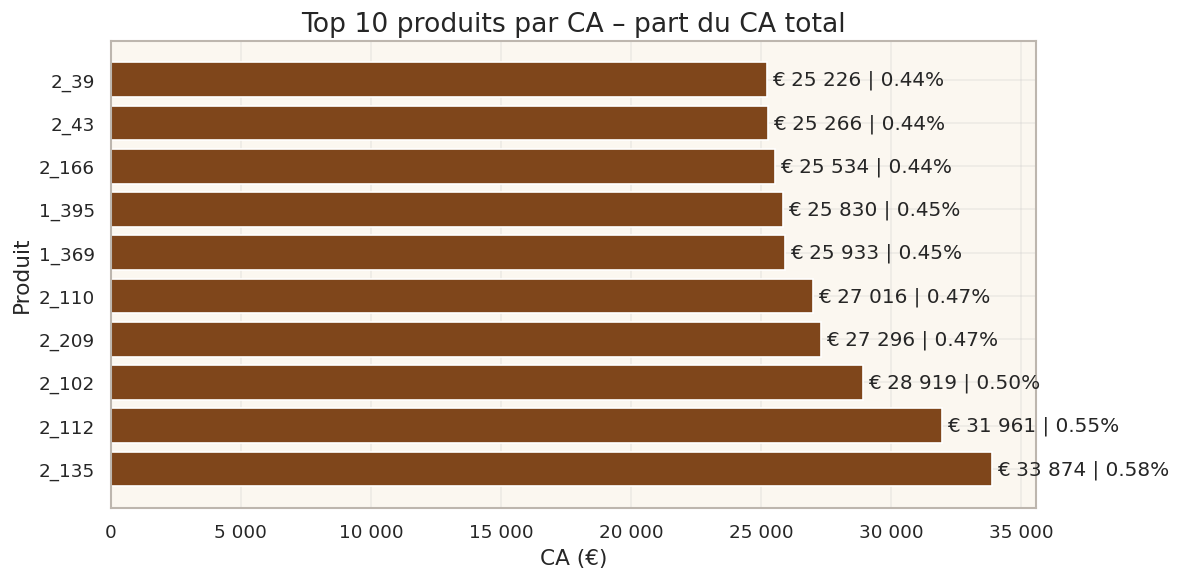

In [ ]:
# ======================
# 3. Analyse par produit
# ======================


# 1) Top 10 produits par CA
top_products = (df_tf.groupby("id_prod")["price"]
                .sum()
                .sort_values(ascending=False)
                .head(10))

# 2) Petit tableau pour calculer la part du CA total
ca_total = df_tf["price"].sum()
top_df = top_products.to_frame(name="price")
top_df["pct_total"] = top_df["price"] / ca_total  # part dans le CA global

# 3) Tracé
fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.barh(y=top_df.index.astype(str), width=top_df["price"])

# 4) Annotations sans boucle: on fabrique un vecteur de textes
labels_text = (
    top_df["price"].apply(lambda v: f"€ {v:,.0f}".replace(",", " "))
    + " | "
    + top_df["pct_total"].apply(lambda p: f"{p:.2%}")
).values

# (matplotlib >= 3.4) pour coller les labels au bout des barres
ax.bar_label(bars, labels=labels_text, label_type="edge", padding=3)

ax.set_title("Top 10 produits par CA – part du CA total")
ax.set_xlabel("CA (€)")
ax.set_ylabel("Produit")
ax.xaxis.set_major_formatter(lambda x, pos: f"{x:,.0f}".replace(",", " "))
plt.tight_layout()
plt.show()

In [ ]:
ptt = df['price']
ptt.value_counts().sort_values().tail(1);
ptt_0 = df.loc[df['categ'] == 0, 'price']
ptt_0.value_counts().sort_values().tail(1);
ptt_1 = df.loc[df['categ'] == 1, 'price']
ptt_1.value_counts().sort_values().tail(1);
ptt_2 = df.loc[df['categ'] == 2, 'price']
ptt_2.value_counts().sort_values().tail(1);

In [ ]:
ptt = df['price']

ptt_0 = df.loc[df['categ'] == 0, 'price']
ptt_1 = df.loc[df['categ'] == 1, 'price']
ptt_2 = df.loc[df['categ'] == 2, 'price']

# --- Vérification des prix les plus fréquents (facultatif) ---
print("Prix le plus fréquent (tous produits) :", ptt.value_counts().sort_values().tail(1))
print("Prix le plus fréquent (catégorie 0) :", ptt_0.value_counts().sort_values().tail(1))
print("Prix le plus fréquent (catégorie 1) :", ptt_1.value_counts().sort_values().tail(1))
print("Prix le plus fréquent (catégorie 2) :", ptt_2.value_counts().sort_values().tail(1))


Prix le plus fréquent (tous produits) : price
15.99    9957
Name: count, dtype: int64
Prix le plus fréquent (catégorie 0) : price
4.99    8422
Name: count, dtype: int64
Prix le plus fréquent (catégorie 1) : price
15.99    4780
Name: count, dtype: int64
Prix le plus fréquent (catégorie 2) : price
68.99    1009
Name: count, dtype: int64


Les 10 produits les plus vendus génèrent chacun entre 25 k€ et 34 k€ sur la période, soit 0,44 % à 0,58 % du CA total. Cela montre que le chiffre d’affaires n’est pas concentré sur quelques références, mais réparti sur un très grand nombre de produits. Même le produit leader (2_135) ne représente que 0,6 % du CA global.


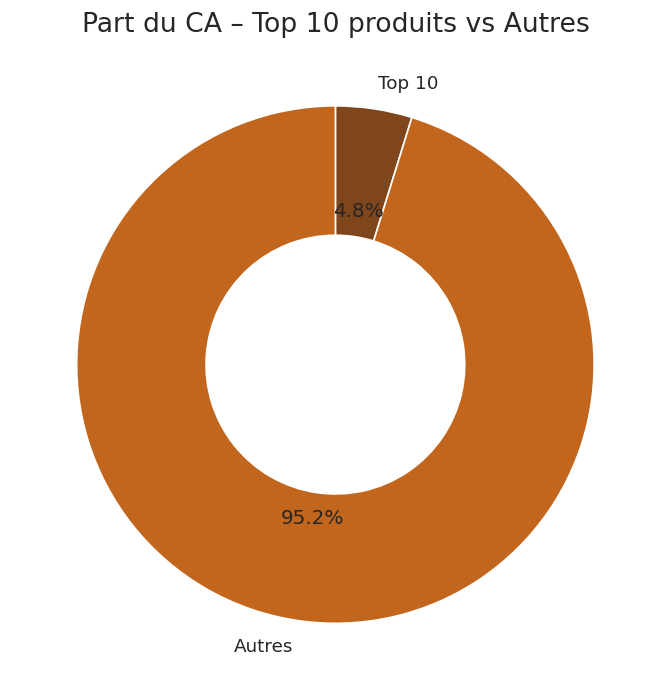

In [ ]:
# Donut Top10 vs Autres (contexte global)
top10_sum = top_products.sum()
others_sum = ca_total - top10_sum

fig, ax = plt.subplots(figsize=(6, 6))
wedges, texts, autotexts = ax.pie(
    [top10_sum, others_sum],
    labels=["Top 10", "Autres"],
    autopct=lambda p: f"{p:.1f}%",
    startangle=90,
    counterclock=False
)
# Donut (anneau)
for w in wedges:
    w.set_width(0.5)

ax.set_title("Part du CA – Top 10 produits vs Autres")
plt.tight_layout()
plt.show()

In [ ]:
# 1. CA par catégorie
ca_by_categ = df.groupby("categ", as_index=False)["price"].sum()

# 2. Effectifs par catégorie
effectif = df['categ'].value_counts().reset_index()
effectif.columns = ["categ", "effectif"]

# 3. Taille totale pour les fréquences
n_total = len(df)
effectif["frequence"] = effectif["effectif"] / n_total

# 4. Fusionner volume + CA
tab = effectif.merge(ca_by_categ, on="categ", how="left").fillna(0)

# 5. Ajouter % du CA total
ca_total = df["price"].sum()
tab["pct_CA"] = tab["price"] / ca_total

# 6. Trier par CA décroissant
tab = tab.sort_values("price", ascending=False).reset_index(drop=True)

tab


,categ,effectif,frequence,price,pct_CA
0,1,108069,0.34,2213622.09,0.40
1,0,190675,0.61,2030504.71,0.37
2,2,16392,0.05,1233291.01,0.23


In [ ]:
df.groupby("categ")["id_prod"].nunique()

,id_prod
categ,
0,2289
1,737
2,236


<Axes: title={'center': 'Nombre de produits uniques par catégorie'}, xlabel='categ'>

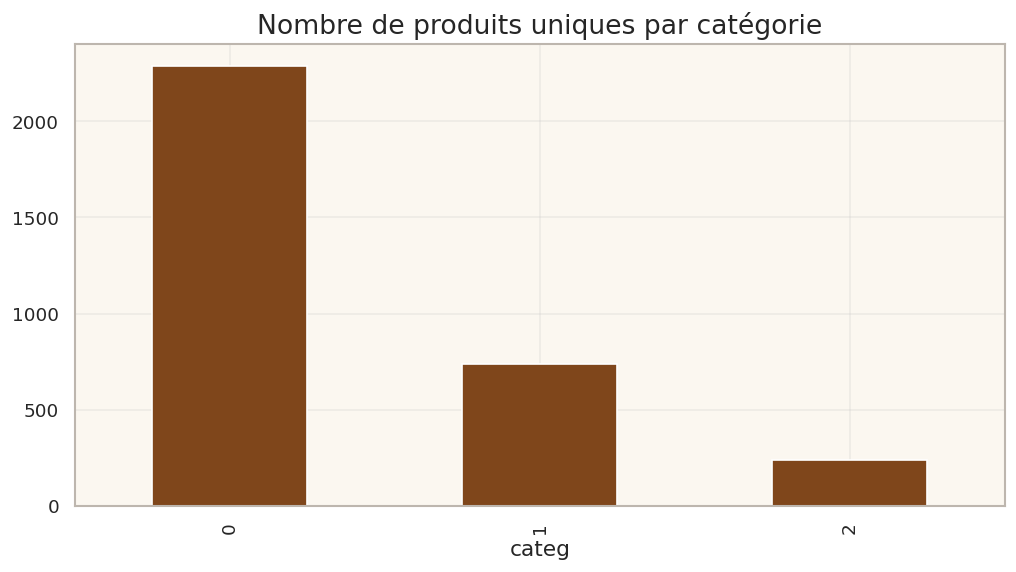

In [ ]:
df.groupby("categ")["id_prod"].nunique().plot(kind="bar", title="Nombre de produits uniques par catégorie")

In [ ]:
# Produits vendus (ceux qui apparaissent dans au moins une session)
produits_vendus = set(df.loc[df["session_id"].notna(), "id_prod"].unique())

# Tous les produits (dans la table)
tous_produits = set(df["id_prod"].unique())

# Produits jamais vendus
produits_non_vendus = tous_produits - produits_vendus

print(f"Nombre de produits jamais vendus : {len(produits_non_vendus)}")
print(f"Produits non vendus : {list(produits_non_vendus)[:10]}")

Nombre de produits jamais vendus : 0
Produits non vendus : []


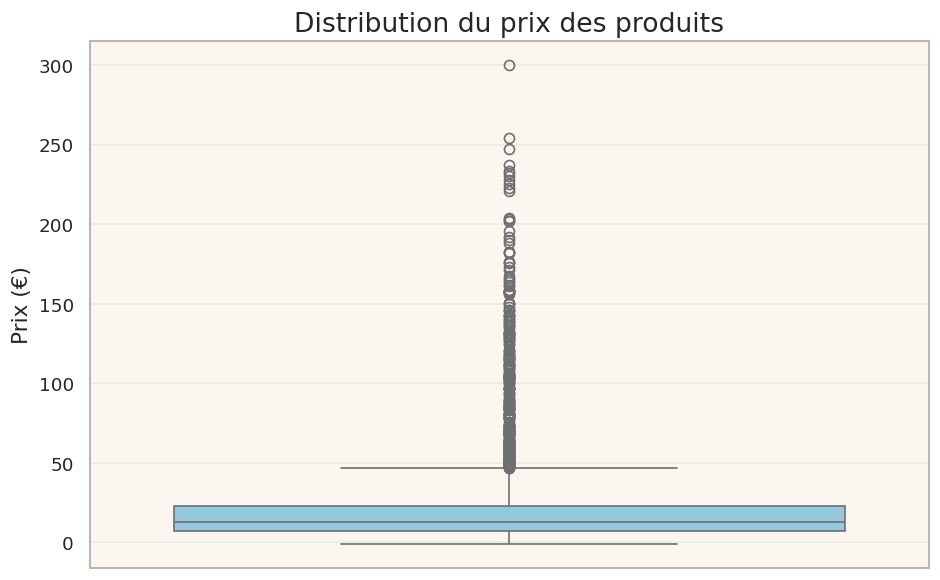

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df_products, y="price", color="skyblue", showfliers=True)
plt.title("Distribution du prix des produits")
plt.ylabel("Prix (€)")
plt.xlabel("")
plt.tight_layout()
plt.show()

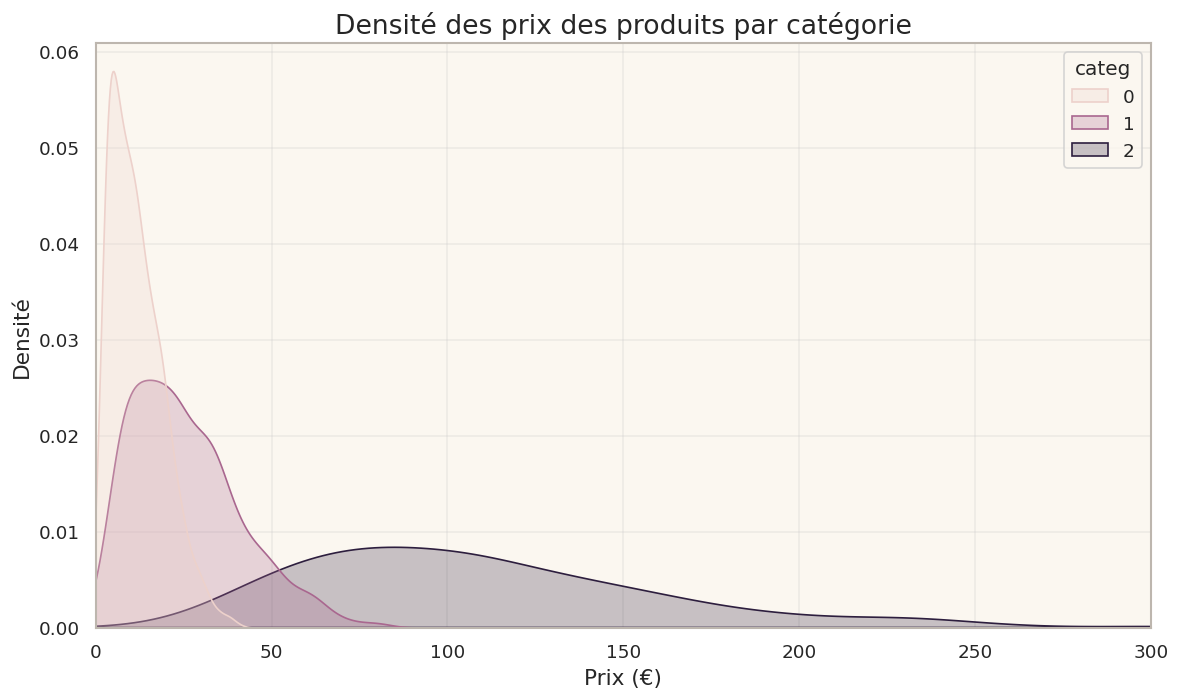

In [ ]:
plt.figure(figsize=(10,6))
sns.kdeplot(data=df_products, x="price", hue="categ", fill=True, common_norm=False)
plt.title("Densité des prix des produits par catégorie")
plt.xlabel("Prix (€)")
plt.ylabel("Densité")
plt.xlim(0, 300)  # ajuste selon tes valeurs max
plt.tight_layout()
plt.show()

L’analyse par catégorie met en évidence trois profils distincts :

* **Catégorie 0** – Produits “courants”
Produits à faible prix unitaire et fort volume : ils représentent 62 % des ventes mais seulement 38 % du chiffre d’affaires.
Les boxplots montrent une distribution de prix resserrée autour de la médiane (~10 €), avec peu de dispersion.
 **Ces articles constituent le socle du volume, mais contribuent modestement à la rentabilité.**

* **Catégorie 1** – Produits “équilibrés”
Représentent 33 % des ventes pour 39 % du CA.
Leurs prix sont modérés (médiane autour de 15 €) et plus homogènes, traduisant un positionnement milieu de gamme.
**Cette catégorie agit comme un stabilisateur : elle combine volume régulier et marge moyenne.**

* **Catégorie 2** – Produits à forte valeur
Peu vendus (5 % du volume) mais contribuent à 23 % du CA.
Le boxplot révèle une forte dispersion des prix, avec des valeurs médianes nettement plus élevées (> 100 €) et plusieurs outliers dans le haut du spectre (> 200–300 €).
**Ces produits sont clairement haut de gamme, essentiels à la rentabilité globale malgré leur faible fréquence d’achat.**

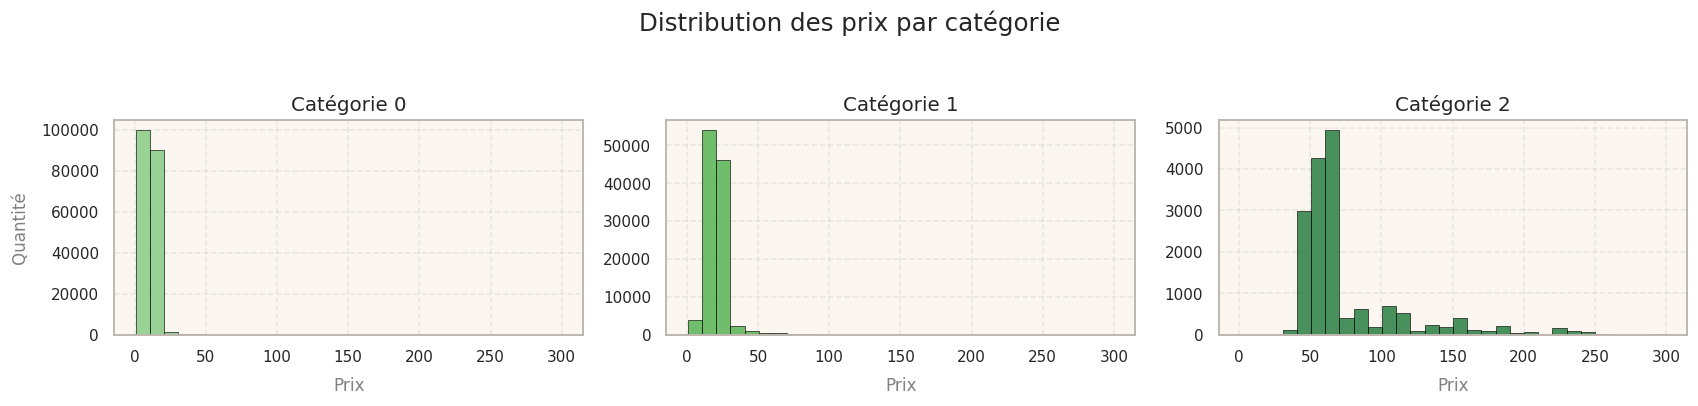

In [ ]:
# Nettoyage léger : garde les lignes avec prix valides
df_ok = df.loc[df["price"].notna()].copy()

# Catégories ordonnées (évite de supposer 0/1/2)
cats = sorted(df_ok["categ"].dropna().unique())

# Prépare les axes (1 ligne, n colonnes)
fig, axes = plt.subplots(1, len(cats), figsize=(5.2*len(cats), 3.5), dpi=110)

# Si une seule catégorie -> axes n’est pas un array
if len(cats) == 1:
    axes = np.array([axes])

# Palette simple (verts) ou multicolore selon ton choix
# Ici : 3 teintes de vert, mais on boucle si >3 catégories
base_colors = ['#7fc97f', '#4daf4a', '#1b7837']
colors = [base_colors[i % len(base_colors)] for i in range(len(cats))]

# Bornes de bins homogènes sur toutes catégories (comparabilité)
pmin = max(0, np.nanmin(df_ok["price"]))
pmax = np.nanmax(df_ok["price"])
bins = np.linspace(pmin, pmax, 31)  # 30 classes

for ax, cat, col in zip(axes.flatten(), cats, colors):
    x = df_ok.loc[df_ok["categ"] == cat, "price"]
    ax.hist(x, bins=bins, alpha=0.8, color=col, edgecolor='black', linewidth=0.5)
    ax.set_title(f'Catégorie {cat}', fontsize=13)
    ax.grid(linestyle='--', alpha=0.4)
    ax.tick_params(labelsize=10, pad=4)
    ax.set_xlabel("Prix", color='gray', labelpad=8, fontsize=11)

# Label Y uniquement sur le premier sous-graphe
axes.flatten()[0].set_ylabel("Quantité", color='gray', labelpad=8, fontsize=11)

plt.suptitle("Distribution des prix par catégorie", y=1.05, fontsize=16)
plt.tight_layout()
plt.show()

**Catégorie 0 – Produits courants**

Concentration très forte sur des prix inférieurs à 20 €, avec une distribution très resserrée.

Volume très élevé (plus de 100 000 produits).

➜ Produits d’entrée de gamme, à forte rotation mais faible marge unitaire.

**Catégorie 1 – Produits milieu de gamme**

Distribution également concentrée en dessous de 50 €.

Un outlier isolé autour de 280 € indique un produit anormalement cher (probablement une erreur ou un cas exceptionnel).

➜ Segment équilibré, représentatif d’une offre de prix standardisée.

**Catégorie 2 – Produits haut de gamme**

Distribution plus étalée, avec une médiane autour de 80–100 €, et des produits allant jusqu’à 250–300 €.

Volume plus faible, mais valeurs nettement plus élevées.

➜ Produits à forte valeur ajoutée, orientés rentabilité.

####Analyse CA par sexe

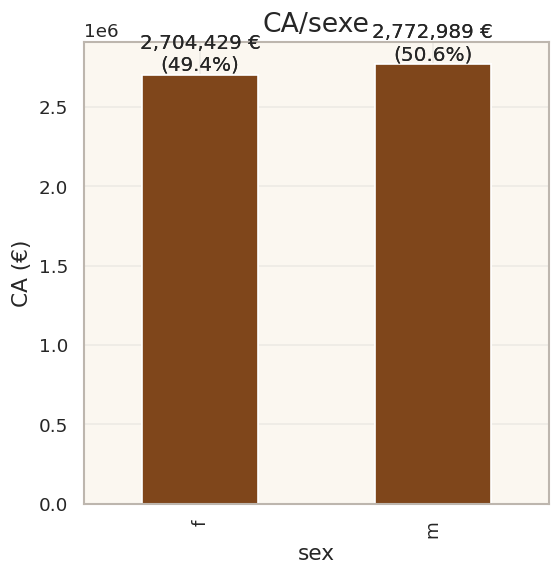

In [ ]:

ca_by_sex = df.groupby("sex")["price"].sum()

#Fréquences cumulées
tab = tab.sort_values("categ") # tri des valeurs de la variable X (croissant)
tab["F"] = tab["frequence"].cumsum() # cumsum calcule la somme cumulée
tab

#diagramme
plt.figure(figsize=(20,4))
ca_by_sex.plot(kind="bar", title="CA parsexe")
plt.ylabel("CA (€)")
plt.xlabel("Sexe")

#ajout des pourcentages
ax = ca_by_sex.plot(kind="bar", figsize=(5,5), title="CA/sexe", legend=False)
ax.set_ylabel("CA (€)")

for p in ax.patches:
    value = p.get_height()
    pct = value / ca_by_sex.sum()
    ax.annotate(f"{value:,.0f} €\n({pct:.1%})",
                (p.get_x() + p.get_width()/2, value),
                ha="center", va="bottom")
plt.show()

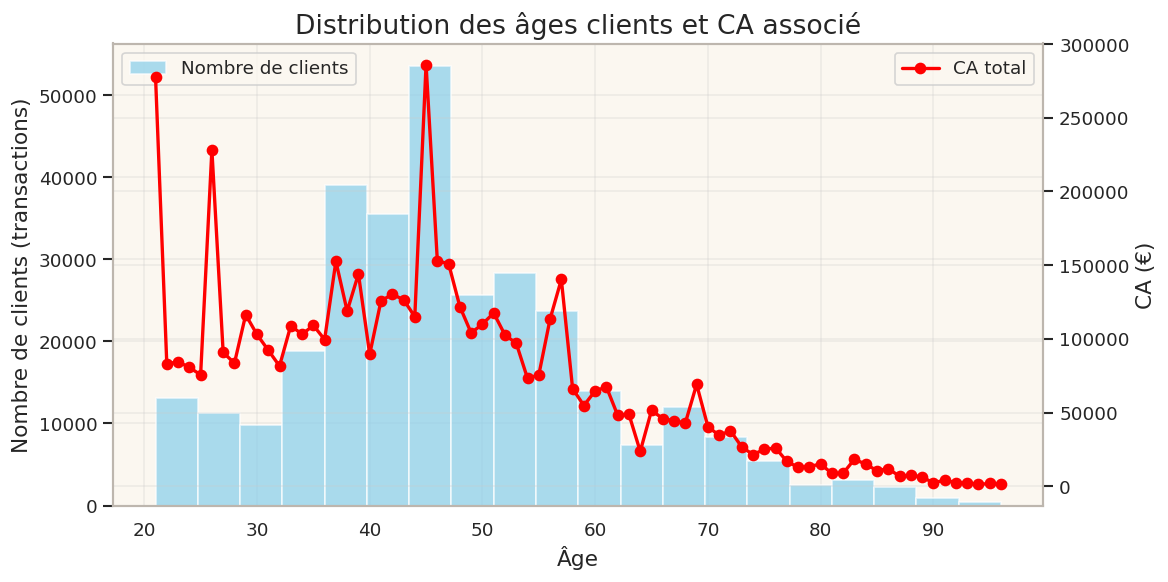

In [ ]:
# Histogramme des effectifs par âge
plt.figure(figsize=(10,5))

ax1 = plt.gca()
df["age"].hist(bins=20, ax=ax1, color="skyblue", alpha=0.7)
ax1.set_title("Distribution des âges clients et CA associé")
ax1.set_xlabel("Âge")
ax1.set_ylabel("Nombre de clients (transactions)")

# Courbe CA total par âge
ax2 = ax1.twinx()
ca_by_age = df.groupby("age")["price"].sum()
ax2.plot(ca_by_age.index, ca_by_age.values, color="red", marker="o", linewidth=2, label="CA total")
ax2.set_ylabel("CA (€)")

# Légendes combinées
ax1.legend(["Nombre de clients"], loc="upper left")
ax2.legend(["CA total"], loc="upper right")

plt.show()

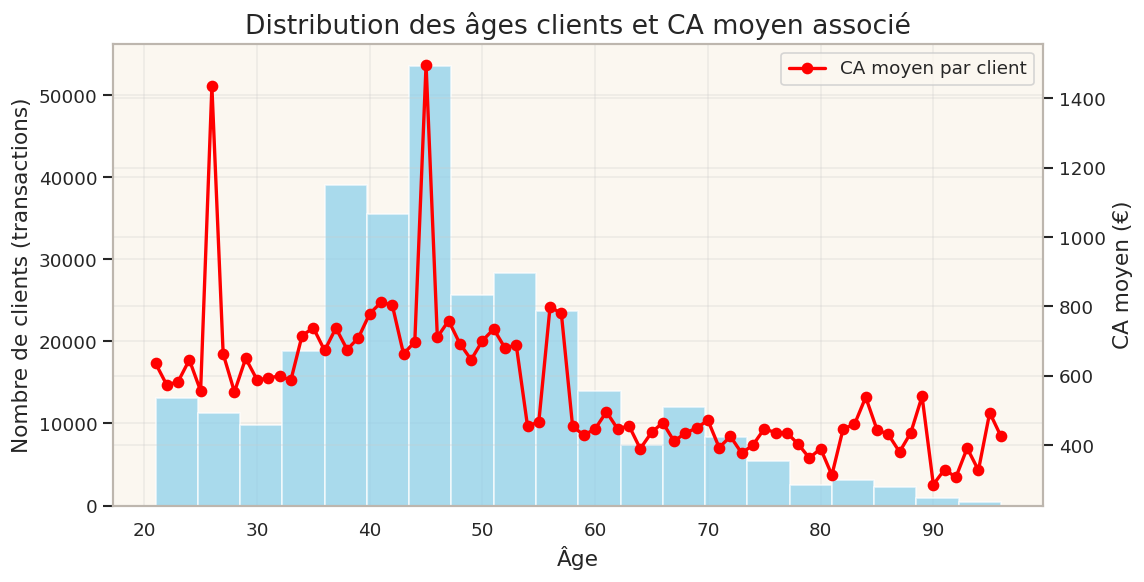

In [ ]:
# CA moyen par âge = CA total / nb de clients distincts par âge
ca_moyen_age = df.groupby("age")["price"].sum() / df.groupby("age")["client_id"].nunique()

plt.figure(figsize=(10,5))
df["age"].hist(bins=20, color="skyblue", alpha=0.7)
plt.title("Distribution des âges clients et CA moyen associé")
plt.xlabel("Âge")
plt.ylabel("Nombre de clients (transactions)")

ax2 = plt.gca().twinx()
ax2.plot(ca_moyen_age.index, ca_moyen_age.values, color="red", marker="o", linewidth=2, label="CA moyen par client")
ax2.set_ylabel("CA moyen (€)")

plt.legend(loc="upper right")
plt.show()


L’analyse par âge montre que la clientèle est surtout concentrée entre 35 et 50 ans en volume.

En termes de valeur :

Le CA moyen par client est le plus élevé chez les **30–55 ans**, confirmant qu’il s’agit de la cible **principale**.

Les clients plus jeunes (<30 ans) et plus âgés (>70 ans) dépensent significativement moins, ce qui réduit leur poids économique malgré leur présence.

Cela suggère que les actions marketing ou de **fidélisation** devraient cibler prioritairement les **30–55 ans**, qui combinent à la fois volume et rentabilité. Mais aussi d'établir une nouvelle stratégie pour **attirer fidéliser** les **jeunes adultes et les seniors.**

###Analyse des prix par categories

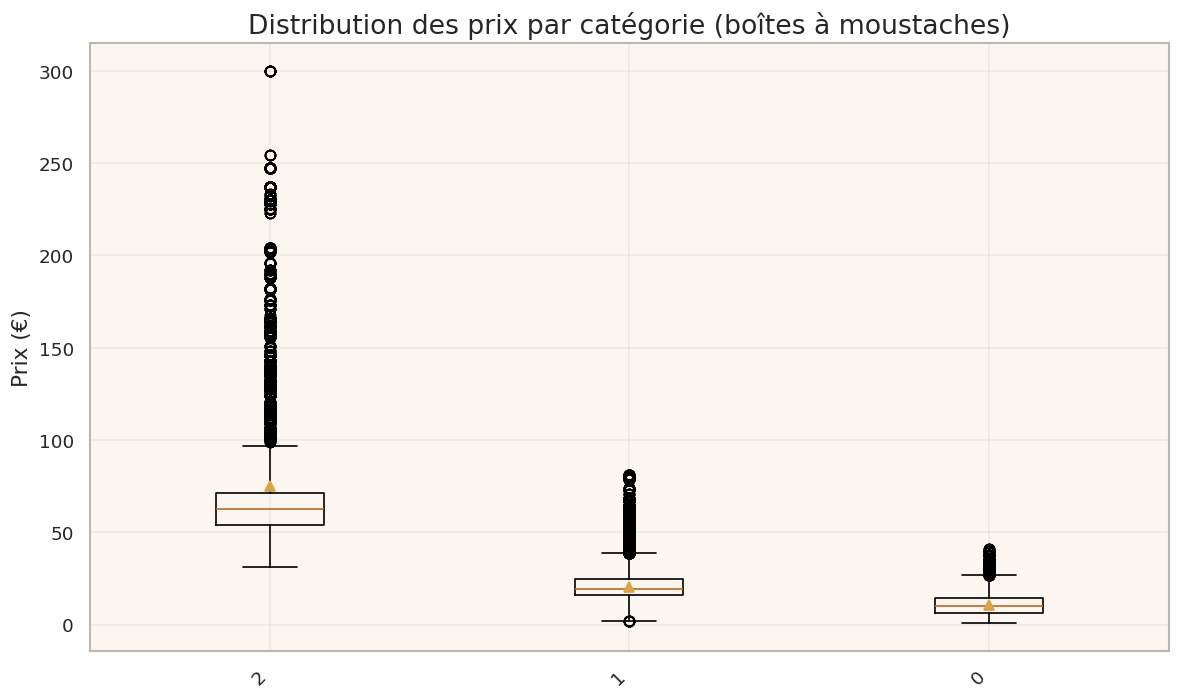

In [ ]:

# Préparer les données : une liste de séries de prix par catégorie
order = (
    df.groupby("categ")["price"]
         .median()
         .sort_values(ascending=False)
         .index.tolist()
)
data = [df.loc[df["categ"] == c, "price"].dropna().values for c in order]

plt.figure(figsize=(10,6))
bp = plt.boxplot(
    data,
    vert=True,
    patch_artist=False,   # pas de couleur imposée
    showfliers=True,      # affiche les outliers
    showmeans=True,       # ligne de moyenne
    whis=1.5
)
plt.xticks(range(1, len(order)+1), order, rotation=45, ha="right")
plt.yscale("linear")      # tu peux passer en 'log' si très asymétrique
plt.title("Distribution des prix par catégorie (boîtes à moustaches)")
plt.ylabel("Prix (€)")
plt.tight_layout()
plt.show()



*  La catégorie 0 regroupe des produits d’entrée de gamme, peu chers ethomogènes.


*   La catégorie 1 se situe dans une gamme intermédiaire, avec des prix plus variés.



*  La catégorie 2 concentre les produits premium, caractérisés par des prix nettement supérieurs et une forte variabilité.


**Cela explique les différences observées dans la contribution au CA par catégorie car la catégorie 2 génère un quart du CA malgré seulement 5 % des volumes.**

## 3. Analyse de concentration : Lorenz & Gini

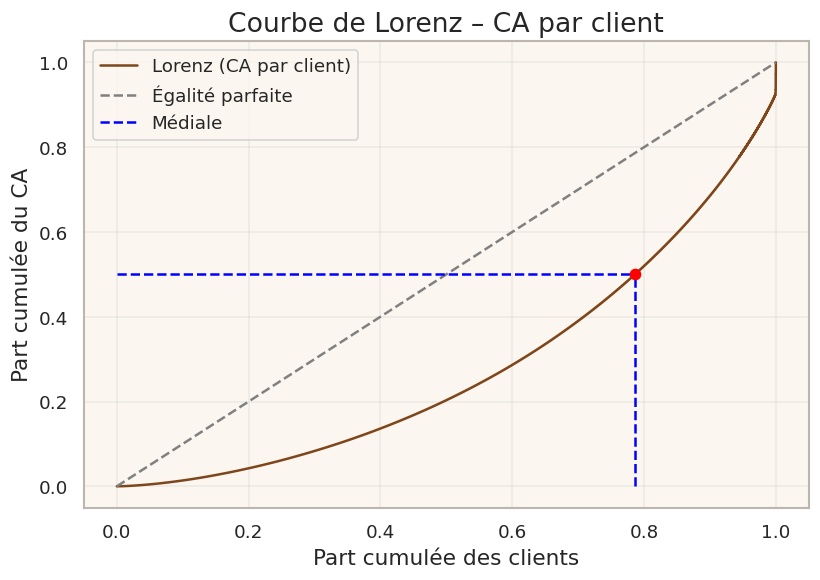

In [ ]:
# CA total par client, trié
ca_clients = df.groupby("client_id")["price"].sum().sort_values().values #On calcule le CA total par client.

# 2) Vecteurs x,y avec origine (0,0)
N = len(ca_clients)
x = np.arange(0, N+1) / N                   #génère une séquence 1, 2, 3, … jusqu’au nombre de clients.
y = np.r_[0.0, ca_clients.cumsum() / ca_clients.sum()]  #ordonnée a l'origine #somme cumulée du CA en suivant l’ordre trié/divise par le total pour obtenir une proportion.

# 3) Tracé courbe de Lorenz
plt.figure(figsize=(7,5))
plt.plot(x, y, drawstyle="steps-post", label="Lorenz (CA par client)")
plt.plot([0,1], [0,1], color="grey", linestyle="--", label="Égalité parfaite")


#tracé médial
idx = np.searchsorted(y, 0.5)   # premier indice où y >= 0.5
x_medial = x[idx]
y_medial = y[idx]
plt.vlines(x_medial, ymin=0, ymax=y_medial, color='blue', linestyle='--', label='Médiale')
plt.hlines(y_medial, xmin=0, xmax=x_medial, color='blue', linestyle='--')
plt.scatter([x_medial], [y_medial], color='red', zorder=5)

#label
plt.xlabel("Part cumulée des clients")
plt.ylabel("Part cumulée du CA")
plt.title("Courbe de Lorenz – CA par client")
plt.legend()
plt.tight_layout()
plt.show()

# 4) Indice de Gini (aire sous la courbe)
AUC = np.trapezoid(y, x)      # aire sous la Lorenz
gini = 1 - 2*AUC

In [ ]:
print(f"50% du CA est atteint par environ {x_medial:.2%} de la population.")
print(f"Indice de Gini (CA par client) : {gini:.3f}")

50% du CA est atteint par environ 78.62% de la population.
Indice de Gini (CA par client) : 0.440


Des produits à forte valeur qui génèrent beaucoup de CA.

Des clients grands comptes ou très réguliers.

Une stratégie commerciale où peu de transactions font l’essentiel du chiffre d’affaires.

Présence d'outlider

## 4. Distribution des ventes

In [ ]:
df["CA"] = df["price"]

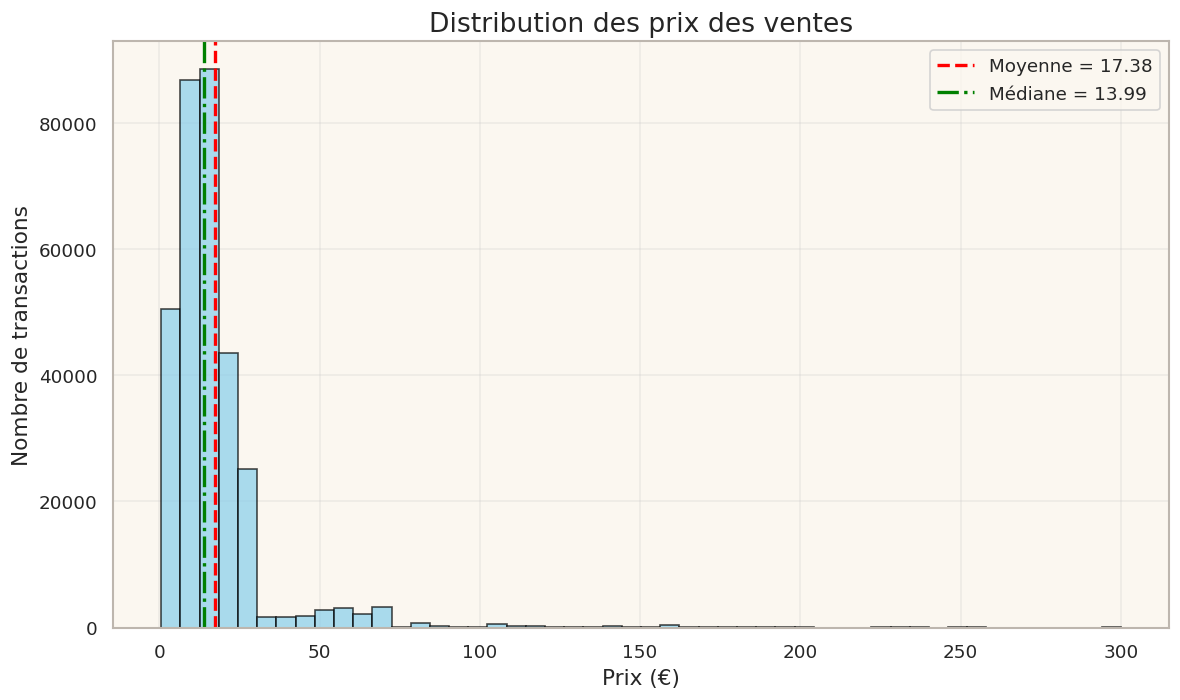

In [ ]:
plt.figure(figsize=(10,6))
plt.hist(df["price"], bins=50, color="skyblue", edgecolor="black", alpha=0.7)

# Ajouter lignes pour moyenne et médiane
plt.axvline(df["price"].mean(), color="red", linestyle="--", linewidth=2, label=f"Moyenne = {df['price'].mean():.2f}")
plt.axvline(df["price"].median(), color="green", linestyle="-.", linewidth=2, label=f"Médiane = {df['price'].median():.2f}")

plt.title("Distribution des prix des ventes")
plt.xlabel("Prix (€)")
plt.ylabel("Nombre de transactions")
plt.legend()
plt.tight_layout()
plt.show()

## 5. Comparaison des ventes selon le sexe

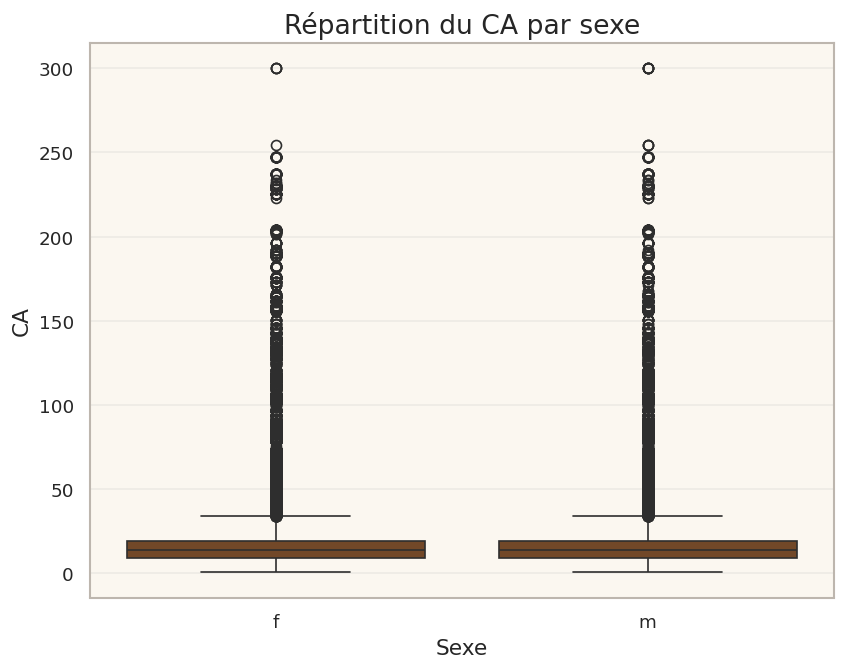

In [ ]:
plt.figure(figsize=(8,6))
sns.boxplot(x='sex', y='CA', data=df)
plt.title('Répartition du CA par sexe')
plt.xlabel('Sexe')
plt.ylabel('CA')
plt.show()

## 6. Analyse temporelle des ventes (par mois)

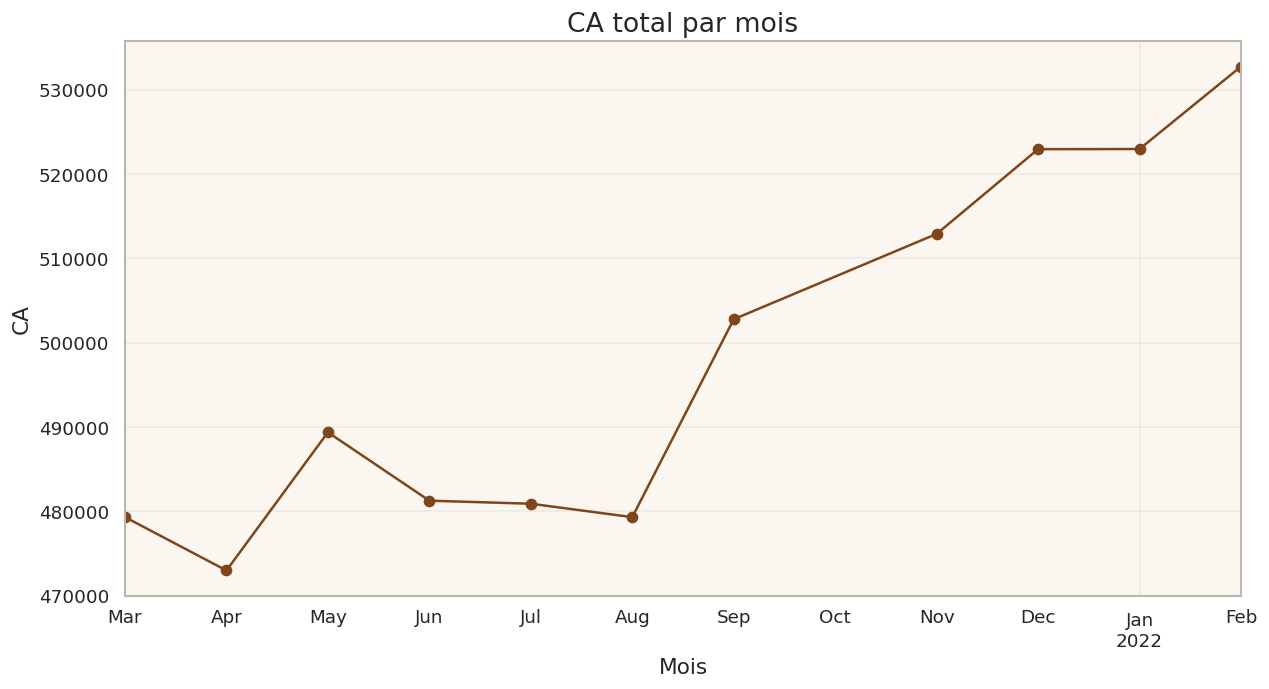

In [ ]:
monthly = df.groupby('month')['CA'].sum()
plt.figure(figsize=(12,6))
monthly.plot(marker='o')
plt.title('CA total par mois')
plt.xlabel('Mois')
plt.ylabel('CA')
plt.grid(True)
plt.show()

## 7. Analyse des ventes par catégorie de produit

/tmp/ipython-input-2812670755.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='categ', y='CA', data=df, estimator=sum, ci=None)


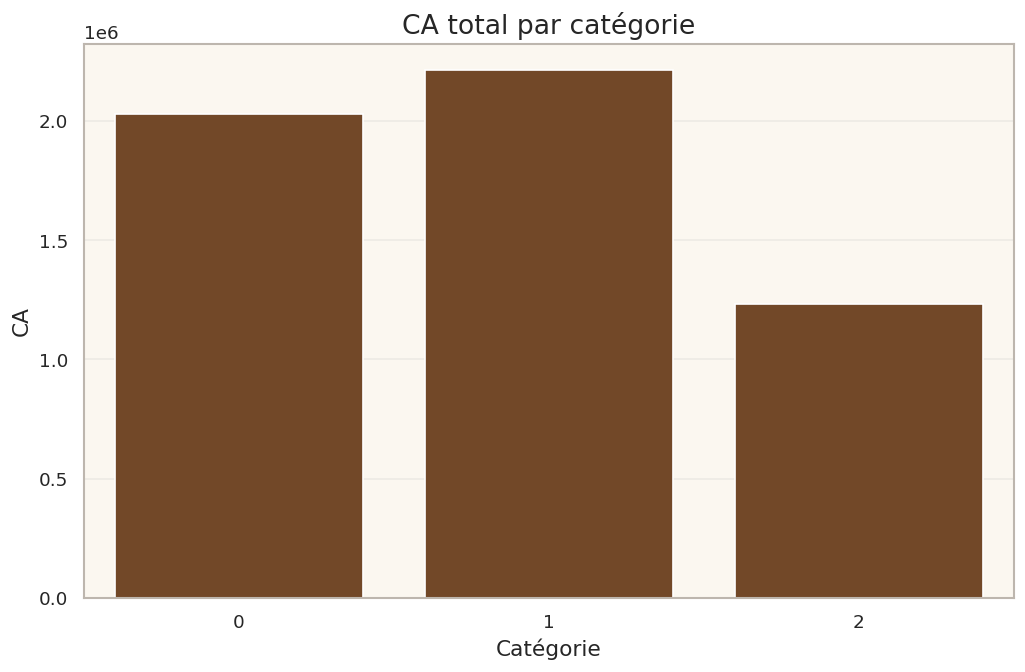

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(x='categ', y='CA', data=df, estimator=sum, ci=None)
plt.title('CA total par catégorie')
plt.xlabel('Catégorie')
plt.ylabel('CA')
plt.show()

## Conclusion
- Les ventes sont concentrées sur quelques transactions (indice de Gini élevé).
- La majorité des montants de vente sont faibles.
- Il existe des pics mensuels dans le chiffre d’affaires.
- Les femmes et hommes achètent de façon similaire en moyenne.
- Certains types de produits génèrent plus de revenus que d'autres.

**Recommandation :** cibler les catégories et périodes les plus rentables, et fidéliser les gros acheteurs.

## Répartition des âges des clients

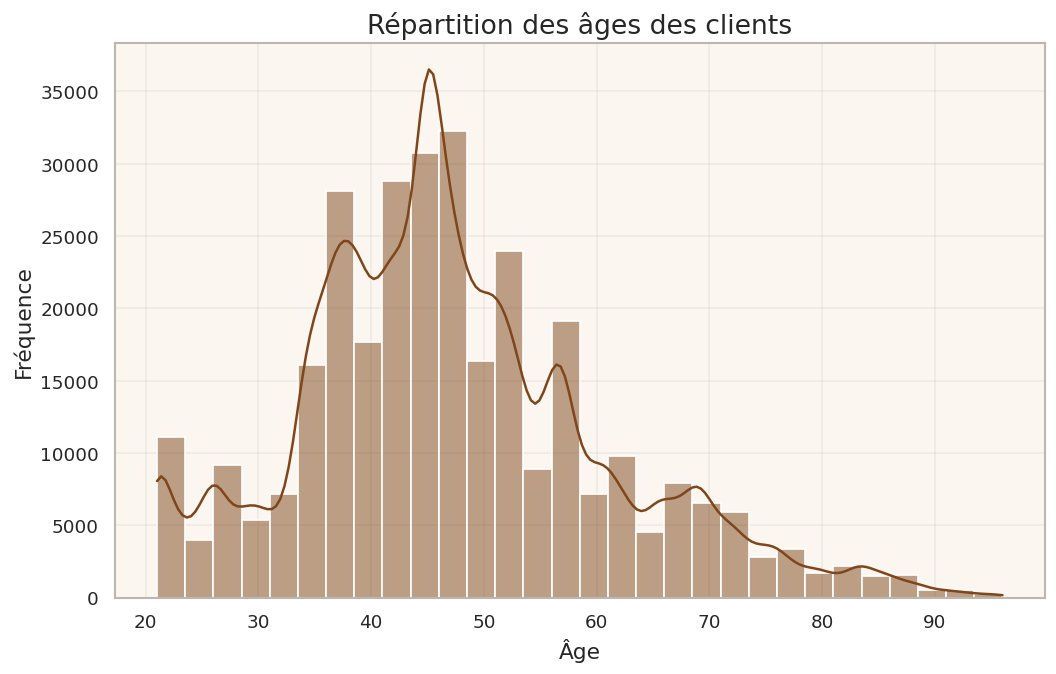

In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(df['age'], bins=30, kde=True)
plt.title('Répartition des âges des clients')
plt.xlabel('Âge')
plt.ylabel('Fréquence')
plt.grid(True)
plt.show()

## Nombre de produits achetés par client

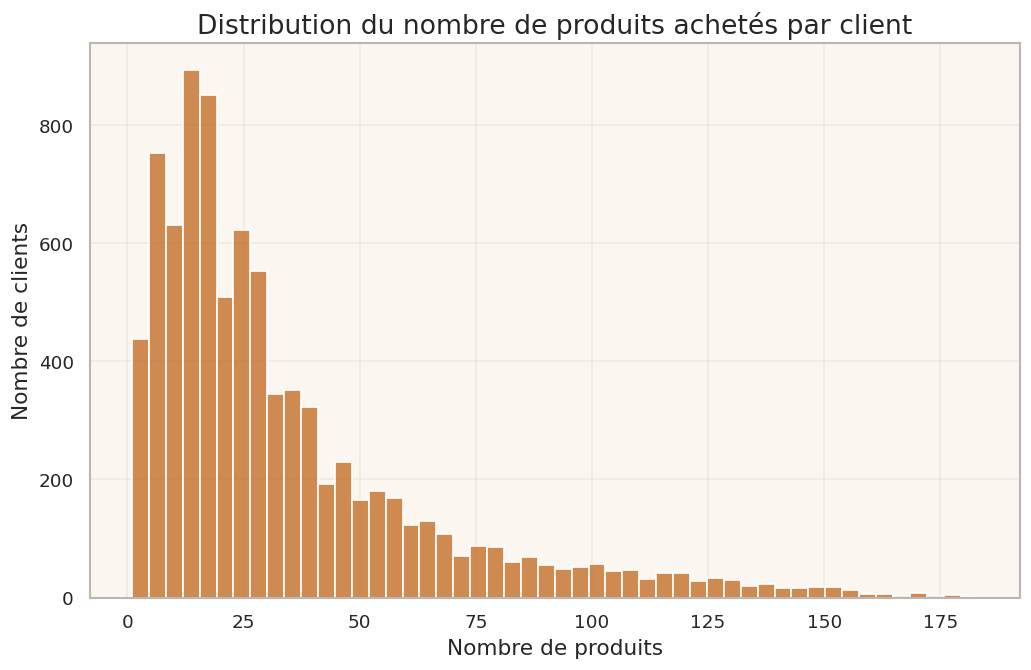

In [ ]:
produits_par_client = df.groupby('client_id')["id_prod"].count()
plt.figure(figsize=(10,6))
sns.histplot(produits_par_client[produits_par_client < 500], bins=50, color="#C1661C")
plt.title("Distribution du nombre de produits achetés par client")
plt.xlabel("Nombre de produits")
plt.ylabel("Nombre de clients")
plt.grid(True, alpha=0.3)
plt.show()

## Nombre de transactions par catégorie de produit

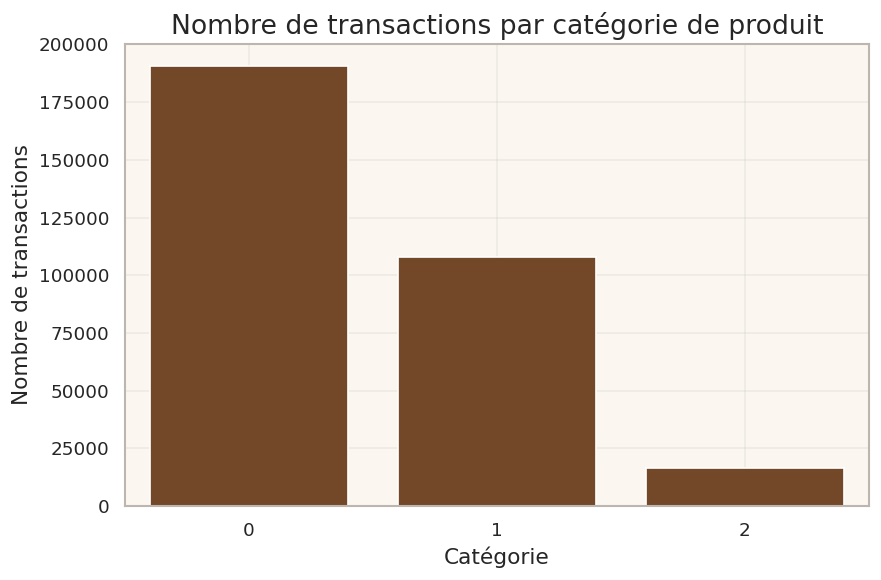

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(x='categ', data=df)
plt.title('Nombre de transactions par catégorie de produit')
plt.xlabel('Catégorie')
plt.ylabel('Nombre de transactions')
plt.grid(True)
plt.show()

## Répartition des prix par catégorie de produit

## Chiffre d'affaires moyen par client

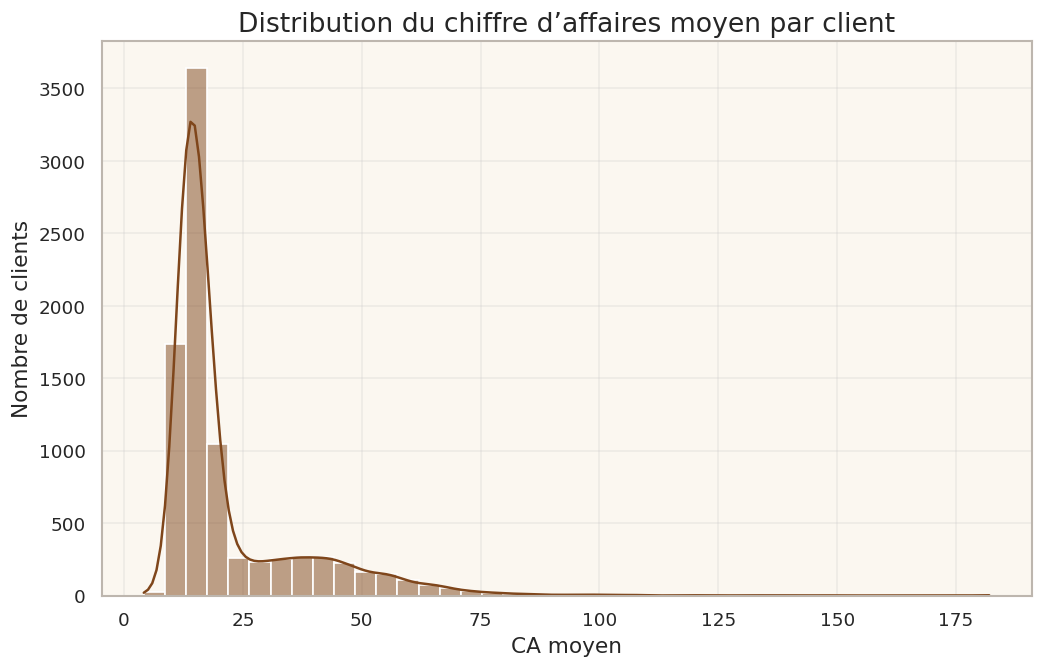

In [ ]:
ca_moyen = df.groupby('client_id')['CA'].mean()
plt.figure(figsize=(10,6))
sns.histplot(ca_moyen, bins=40, kde=True)
plt.title('Distribution du chiffre d’affaires moyen par client')
plt.xlabel('CA moyen')
plt.ylabel('Nombre de clients')
plt.grid(True)
plt.show()

## Top 10 clients en termes de chiffre d’affaires

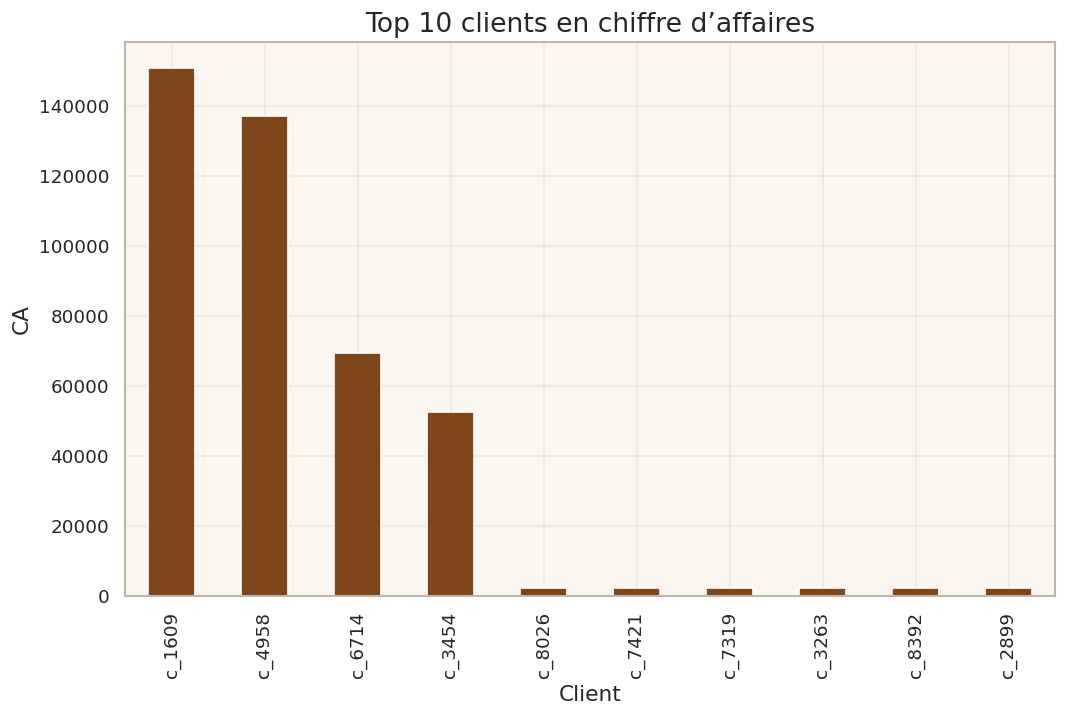

In [ ]:
top_clients = df.groupby('client_id')['CA'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10,6))
top_clients.plot(kind='bar')
plt.title('Top 10 clients en chiffre d’affaires')
plt.xlabel('Client')
plt.ylabel('CA')
plt.grid(True)
plt.show()

## Relation entre l’âge et le chiffre d’affaires

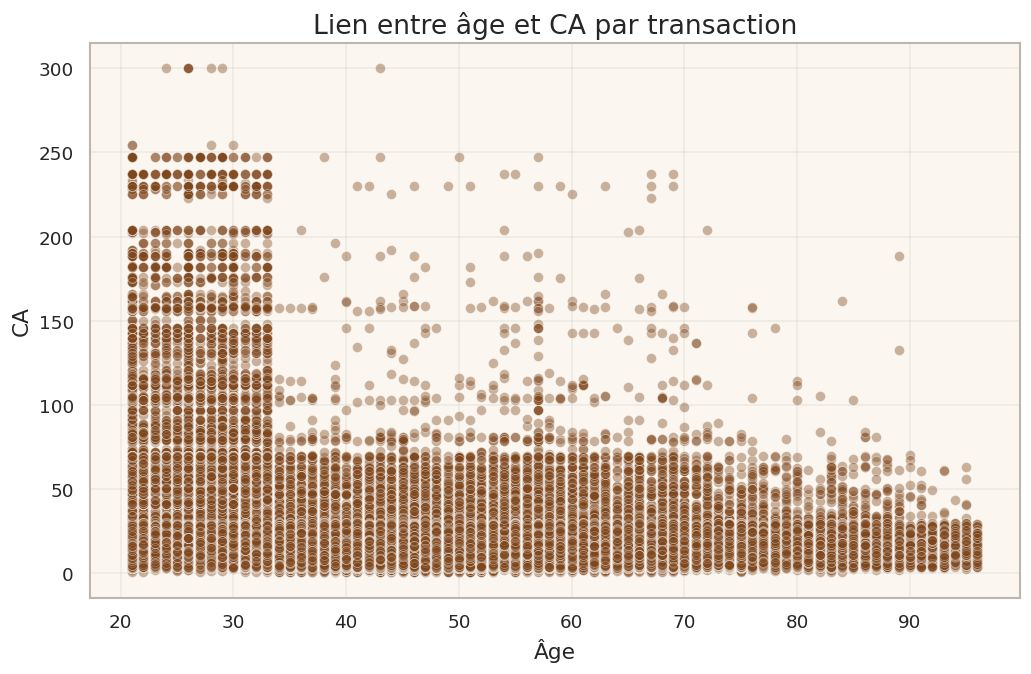

In [ ]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='age', y='CA', data=df, alpha=0.4)
plt.title('Lien entre âge et CA par transaction')
plt.xlabel('Âge')
plt.ylabel('CA')
plt.grid(True)
plt.show()

## Chiffre d’affaires par tranche d’âge

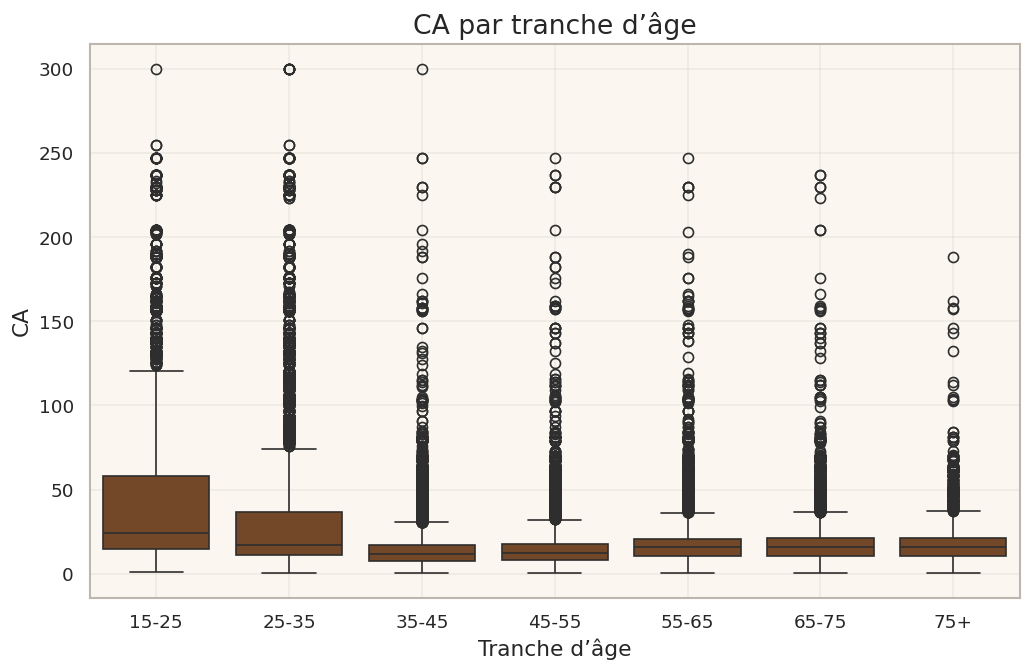

In [ ]:
bins = [15, 25, 35, 45, 55, 65, 75, 100]
labels = ['15-25', '25-35', '35-45', '45-55', '55-65', '65-75', '75+']
df['tranche_age'] = pd.cut(df['age'], bins=bins, labels=labels)
plt.figure(figsize=(10,6))
sns.boxplot(x='tranche_age', y='CA', data=df)
plt.title('CA par tranche d’âge')
plt.xlabel('Tranche d’âge')
plt.ylabel('CA')
plt.grid(True)
plt.show()

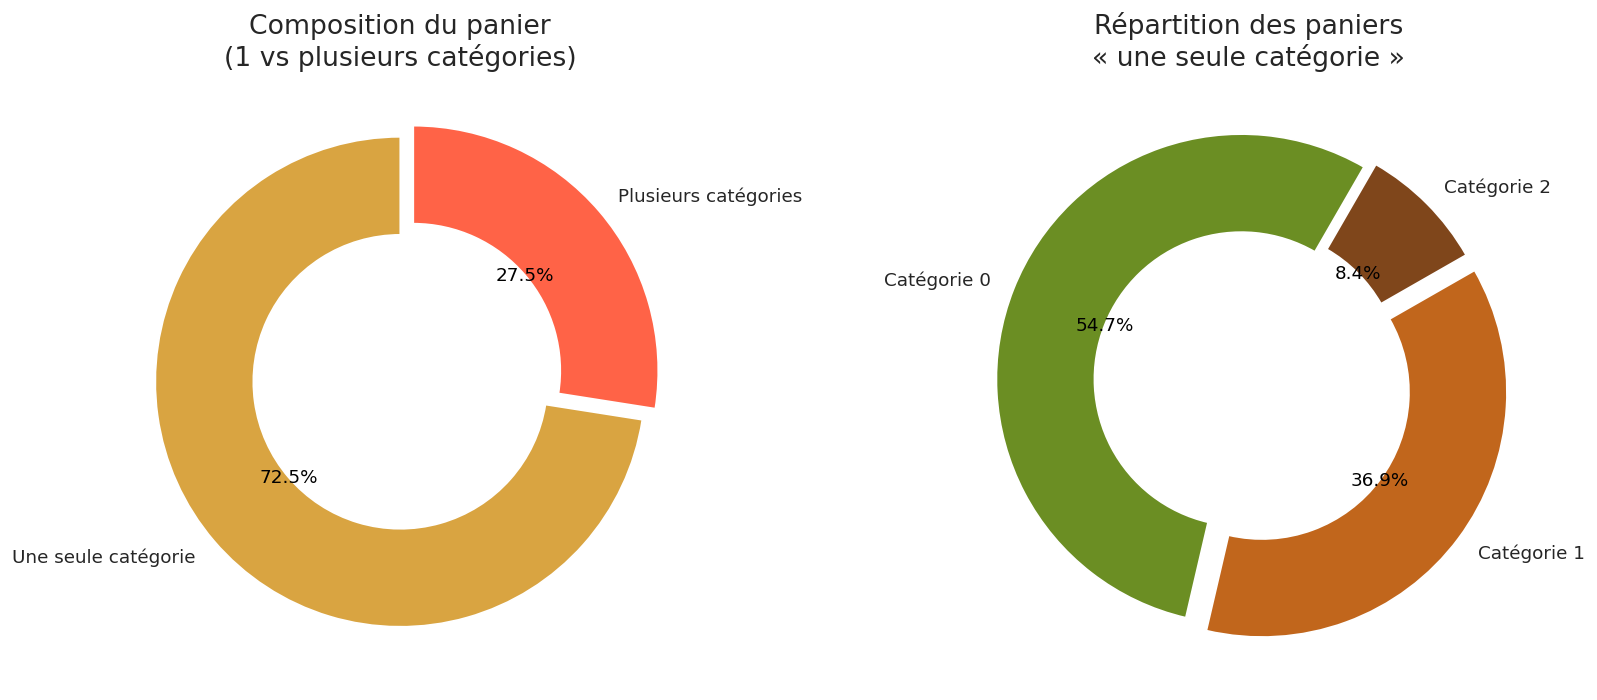

In [ ]:

cats_per_basket = df.groupby("session_id")["categ"].nunique()
n_single = int((cats_per_basket == 1).sum())
n_multi  = int((cats_per_basket > 1).sum())

sizes_left = [n_single, n_multi]
labels_left = ["Une seule catégorie", "Plusieurs catégories"]
colors_left = [PALETTE[2], "tomato"]

# === 2) Répartition des paniers mono par catégorie ===
single_cat = (
    df.groupby("session_id")["categ"]
      .agg(lambda s: s.iloc[0] if s.nunique()==1 else np.nan)
      .dropna()
      .astype(int)
)
share_single = single_cat.value_counts(normalize=True).reindex([0,1,2]).fillna(0)
sizes_right = share_single.values * 100
labels_right = [f"Catégorie {c}" for c in [0,1,2]]
colors_right = [PALETTE[3], PALETTE[1], PALETTE[0]]

# === 3) Création des deux donuts ===
fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=120)

# --- Donut 1 : mono vs multi ---
wedges1, texts1, autotexts1 = axes[0].pie(
    sizes_left,
    labels=labels_left,
    autopct="%.1f%%",
    startangle=90,
    explode=(0, 0.07),
    colors=colors_left,
    wedgeprops=dict(width=0.4, edgecolor="white")
)
axes[0].set_title("Composition du panier\n(1 vs plusieurs catégories)")

# --- Donut 2 : répartition mono par catégorie ---
wedges2, texts2, autotexts2 = axes[1].pie(
    sizes_right,
    labels=labels_right,
    autopct="%.1f%%",
    startangle=60,
    explode=(0.03, 0.07, 0.03),
    colors=colors_right,
    wedgeprops=dict(width=0.4, edgecolor="white")
)
axes[1].set_title("Répartition des paniers\n« une seule catégorie »")

# --- Harmonisation du style ---
for autotexts in [autotexts1, autotexts2]:
    for t in autotexts:
        t.set_color("black")
        t.set_fontsize(11)
for texts in [texts1, texts2]:
    for t in texts:
        t.set_fontsize(11)

plt.tight_layout()
plt.show()

In [ ]:
df['CA'] = df["price"].copy()

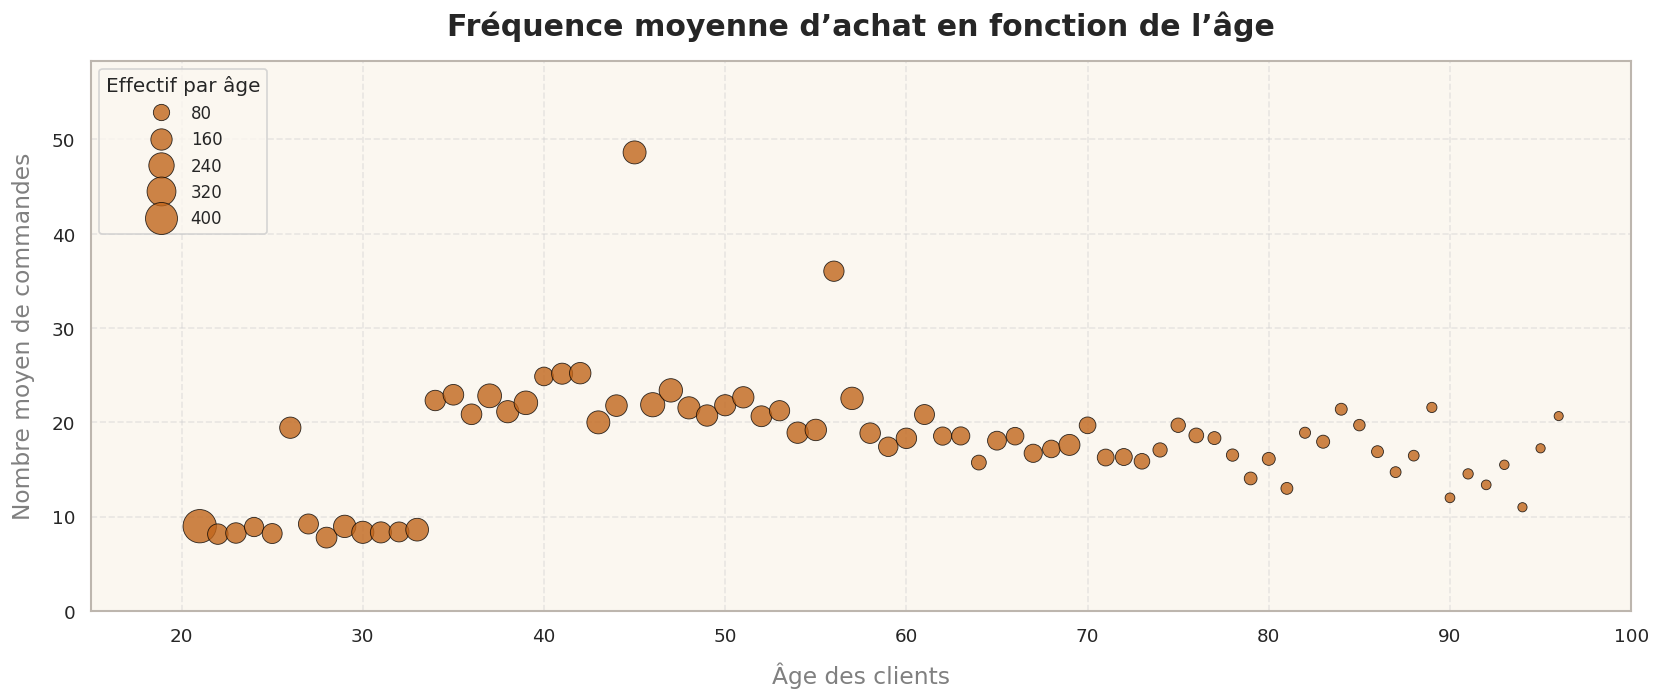

In [ ]:
# --- 1️⃣ Construction de la table freq ---
# Nombre de commandes par client (sessions uniques)
freq_clients = (
    df.groupby("client_id", observed=True)
      .agg(nb_commandes=('session_id', 'nunique'),
           c_age=('age', 'first'))
      .dropna(subset=['c_age'])
      .reset_index(drop=True)
)

# Agrégation par âge : effectif + moyenne des commandes
freq = (
    freq_clients.groupby('c_age', observed=True)
    .agg(effectif_age=('c_age', 'count'),
         nb_commandes_moy=('nb_commandes', 'mean'))
    .reset_index()
)

# --- 2️⃣ Visualisation — bubble chart (plus intuitif qu’une droite de régression brute) ---
plt.figure(figsize=(14, 6), dpi=120)

sns.scatterplot(
    data=freq,
    x='c_age', y='nb_commandes_moy',
    size='effectif_age', sizes=(30, 400),
    color='#C1661C', edgecolor='black', alpha=0.8
)

# --- 3️⃣ Finition graphique ---
plt.xlabel("Âge des clients", fontsize=14, color="gray", labelpad=10)
plt.ylabel("Nombre moyen de commandes", fontsize=14, color="gray", labelpad=10)
plt.title("Fréquence moyenne d’achat en fonction de l’âge", fontsize=18, weight='bold', pad=15)
plt.grid(linestyle='--', alpha=0.4)
plt.xlim(15, 100)
plt.xticks(np.arange(20, 101, 10))
plt.ylim(0, freq['nb_commandes_moy'].max() * 1.2)
plt.legend(title="Effectif par âge", frameon=True, loc="upper left", fontsize=10)
plt.tight_layout()
plt.show()

In [ ]:
# Calcul du panier moyen (CA moyen) par âge
freq2 = (
    freq.groupby('c_age', observed=True)['price']
      .mean()
      .reset_index()
      .rename(columns={'price': 'montant_panier'})
)

# --- 2️⃣ Tracé scatterplot seul ---
plt.figure(figsize=(12, 6), dpi=120)
sns.scatterplot(
    data=r,
    x='c_age',
    y='montant_panier',
    s=70,
    color='#C1661C',        # orange automnal
    edgecolor='black',
    alpha=0.8
)

# --- 3️⃣ Mise en forme esthétique ---
plt.xlabel("Âge des clients", fontsize=14, color="gray", labelpad=10)
plt.ylabel("Montant du panier moyen (€)", fontsize=14, color="gray", labelpad=10)
plt.title("Montant du panier moyen en fonction de l’âge des clients", fontsize=18, weight='bold', pad=15)

plt.xlim(15, 100)
plt.ylim(0, freq2['montant_panier'].max() * 1.1)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

KeyError: 'Column not found: price'

/tmp/ipython-input-116668553.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


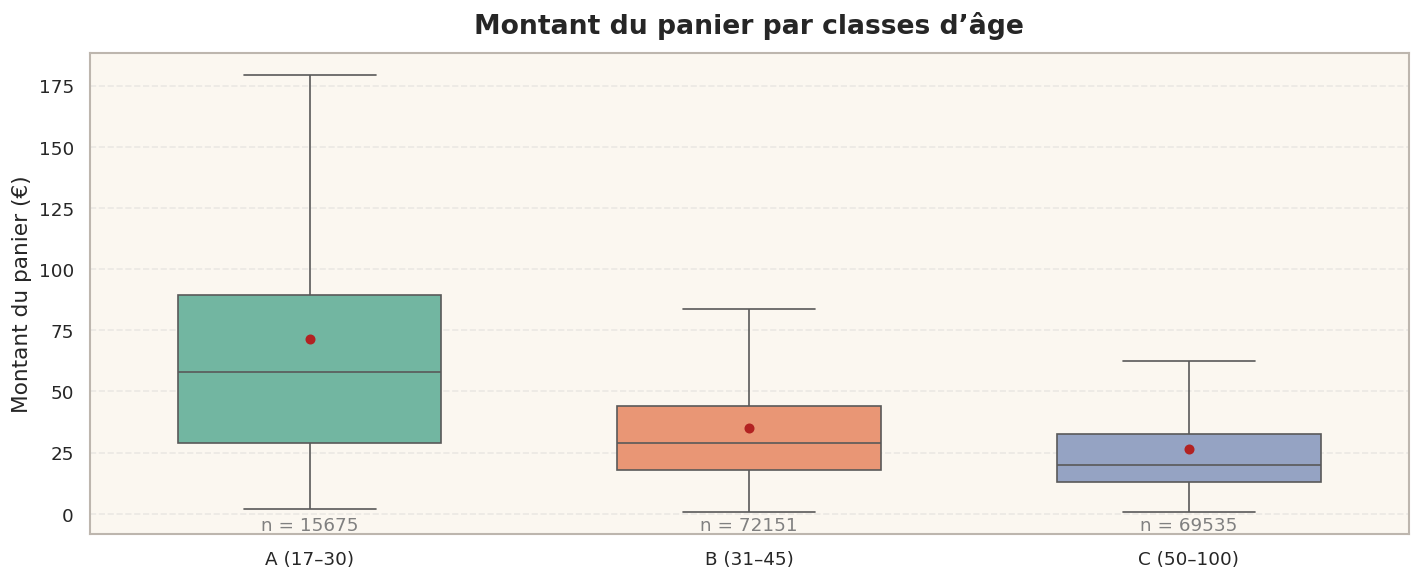

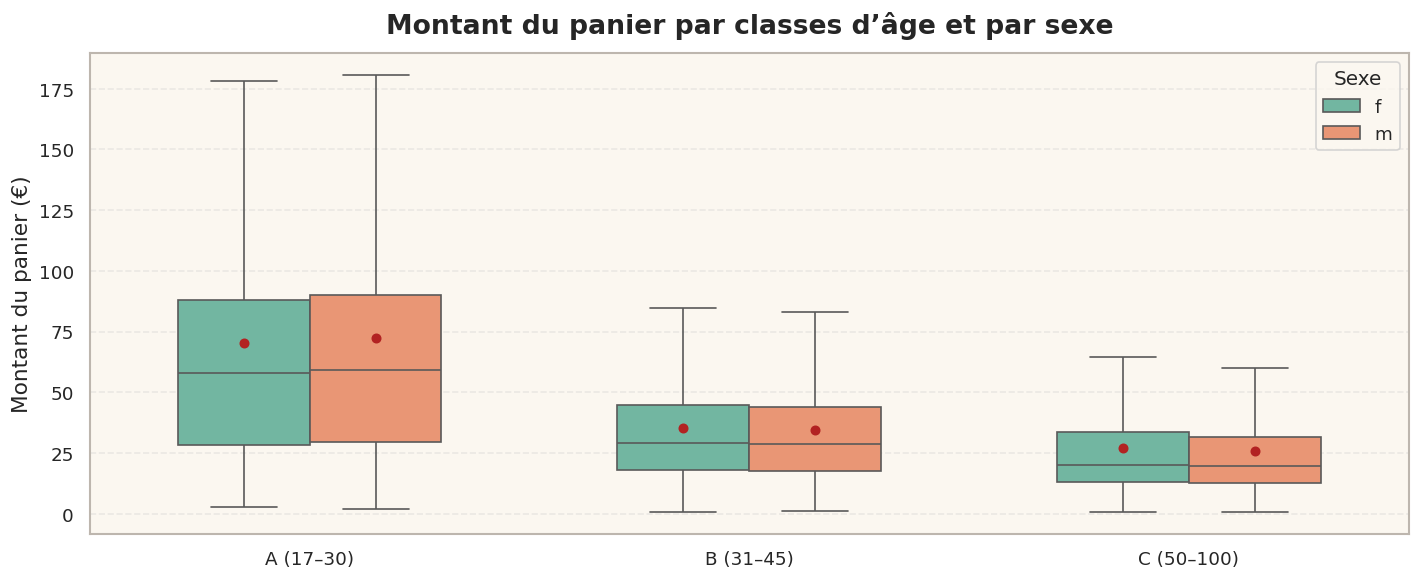

In [ ]:
# 1) Panier par session (somme du CA)
panier = (
    df.groupby("session_id", observed=True)
      .agg(montant_panier=("CA", "sum"),
           age=("age", "first"),
           sex=("sex", "first"))           # adapte si ton sexe est 'c_sex' / 'sex'
      .dropna(subset=["age", "montant_panier"])
      .reset_index(drop=True)
)

# 2) Classes d’âge (A:17–29, B:30–49, C:50–92)
bins  = [17, 30, 50, 93]
labels = ["A (17–30)", "B (31–45)", "C (50–100)"]
panier["classe"] = pd.cut(panier["age"], bins=bins, right=False, labels=labels)

# 3) BOXPlot principal (meilleure représentation : lisible, robuste aux outliers)
plt.figure(figsize=(12, 5), dpi=120)
sns.boxplot(
    data=panier, x="classe", y="montant_panier",
    showfliers=False, width=0.6, palette="Set2",
    showmeans=True, meanprops=dict(marker='o', markersize=5, markerfacecolor='firebrick', markeredgecolor='firebrick')
)
plt.title("Montant du panier par classes d’âge", pad=12, fontsize=16, weight="bold")
plt.xlabel("")
plt.ylabel("Montant du panier (€)")
plt.grid(axis="y", linestyle="--", alpha=0.35)

# Annotation des effectifs n par classe
counts = panier["classe"].value_counts().reindex(labels).fillna(0).astype(int)
for i, lab in enumerate(labels):
    plt.text(i, plt.gca().get_ylim()[0], f"n = {counts.loc[lab]}",
             ha="center", va="bottom", color="gray", fontsize=11)

plt.tight_layout()
plt.show()

# 4) (Optionnel) Détail par sexe
plt.figure(figsize=(12, 5), dpi=120)
sns.boxplot(
    data=panier, x="classe", y="montant_panier", hue="sex",
    showfliers=False, width=0.6, palette="Set2",
    showmeans=True, meanprops=dict(marker='o', markersize=5, markerfacecolor='firebrick', markeredgecolor='firebrick')
)
plt.title("Montant du panier par classes d’âge et par sexe", pad=12, fontsize=16, weight="bold")
plt.xlabel("")
plt.ylabel("Montant du panier (€)")
plt.grid(axis="y", linestyle="--", alpha=0.35)
plt.legend(title="Sexe", frameon=True)
plt.tight_layout()
plt.show()

In [ ]:
client_col = next((col for col in df.columns if "client" in col.lower()), None)
print("🧭 Colonne client détectée :", client_col)

# --- 1️⃣ Calcul de la fréquence d'achat par âge ---
freq_clients = (
    df.groupby(client_col, observed=True)
      .agg(nb_commandes=('session_id', 'nunique'),
           age=('age', 'first'))
      .dropna(subset=['age'])
      .reset_index(drop=True)
)

# --- 2️⃣ Moyenne par âge ---
freq_age = (
    freq_clients.groupby('age', observed=True)
    .agg(
        effectif_age=(client_col, 'count'),
        freq_achat_moy=('nb_commandes', 'mean')
    )
    .reset_index()
)

# --- 3️⃣ Visualisation ---
plt.figure(figsize=(12, 6), dpi=120)
sns.scatterplot(
    data=freq_age,
    x='age',
    y='freq_achat_moy',
    size='effectif_age', sizes=(30, 400),
    color='#C1661C', edgecolor='black', alpha=0.8
)

plt.xlabel("Âge des clients", fontsize=14, color="gray", labelpad=10)
plt.ylabel("Fréquence moyenne d'achat (commandes / client)", fontsize=14, color="gray", labelpad=10)
plt.title("Fréquence moyenne d’achat par âge", fontsize=18, weight='bold', pad=15)
plt.grid(linestyle='--', alpha=0.4)
plt.xlim(15, 100)
plt.tight_layout()
plt.show()

🧭 Colonne client détectée : client_id


KeyError: "Column(s) ['client_id'] do not exist"